In [27]:
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import re
import cftime
from datetime import datetime
from dask.diagnostics import ProgressBar
from scipy.stats import t
from scipy.stats import linregress
from eofs.xarray import Eof
from eofs.examples import example_data_path
import calendar
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from types import SimpleNamespace
from netCDF4 import Dataset


In [29]:
def linregress_1d(y, x=None):
    """
    Linear regression for a single 1D array vectorisied over space
    Returns the slope, intercept, pvalue and std error.
    """
    if x is None:
        x = np.arange(len(y))
    if np.all(np.isfinite(y)):
        res = linregress(x, y)
        return np.array([res.slope, res.intercept, res.pvalue, res.stderr])
    else:
        return np.full(4, np.nan)

def NAtlantic_check_EOF(eof: xr.DataArray, max_modes:int) -> xr.DataArray:
    """
    Checks that the EOF is aligned as standard for the North Atlantic
    """
    eof_aligned = eof.copy()

    for n in range(max_modes):
        mode = eof_aligned.sel(mode=n)

        if n == 0:
            ref = mode.sel(lat=65, lon=-20, method='nearest')
            if ref.values > 0:
                eof_aligned.loc[dict(mode=n)] = -mode

        if n ==1:
            ref = mode.sel(lat=40, lon=-10, method='nearest')
            if ref.values < 0:
                eof_aligned.loc[dict(mode=n)] = -mode         
    
    return eof_aligned

class EnsembleMemberCalculations:
    def __init__(self, data_path: Path, model=None, member_id=None):
        #use self. to access attributes
        self.data_path = Path(data_path)
        
        #referencing the parent model and setting up shortcuts
        self.model = model
        self.experiment = model.experiment if model else None
        self.all_experiments = self.experiment.all_experiments if self.experiment else None

        if member_id is not None:
            #manually overriding the naming function - for adding observations in. - what is passed through as member_id
            self.member_id = member_id
        else:
            #extracting the member_id (ensemble number) from the filename as named in CMIP6 convention
            match = re.search(r"(r\d+i\d+p\d+f\d+)", self.data_path.stem)
            if not match:
                raise ValueError(f"Could not extract the member_id from filename: {self.data_path.name}")
            #selecting the ensemble number and assigning it to the member ID
            self.member_id = match.group(1)


        self.data = None

    def load_data(self):
        #loads the data of an ensemble member
        self.data = xr.open_dataset(self.data_path)

        #normalisation for the era5 dataset
        if self.model and self.model.name == "era5":
            self.normalise_era5()
            
        return self.data

    def normalise_era5(self):
        """
        Basically fix the coordinates lat/lon shift for era5
        Also rename msl - psl, latitude - lat and longitude - lon
        """

        print('normalising era5')
        ds = self.data
    
        #renaming msl to psl
        if "msl" in ds.variables and "psl" not in ds.variables:
            ds = ds.rename({"msl": "psl"})


        #change to lat/lon
        coord_map = {}
        if "latitude" in ds.dims:
            coord_map["latitude"] = "lat"
        if "longitude" in ds.dims:
            coord_map["longitude"] = "lon"
        if coord_map:
            ds = ds.rename(coord_map)

        #shift the lon from [0,...,360] to [-180,...,180]
        if (ds.lon > 180).any():
            new_lon = np.where(ds.lon > 179, ds.lon - 360, ds.lon)
            ds = ds.assign_coords(lon=new_lon)

            #Making sure they are sorted in ascending order
            sorted_lon = np.sort(ds.lon)
            ds = ds.sel(lon=sorted_lon)

        #Also ensure that lats are sorted in ascending order
        if ds.lat.values[0] > ds.lat.values[-1]:
            ds = ds.reindex(lat=list(reversed(ds.lat)))

        print(ds)

        self.data = ds
        #COMMENT THIS OUT!!!!!
        #return self.data

    def get_calendar_type(self):
        if self.model is None:
            raise RuntimeError("Model is not set")
        return self.model.calendar_type

    def get_time_bounds(self):
        """
        Access the model's time_bounds - each model has a different calendar thus type of time to index/slice by
        """
        if self.model is None or self.model.time_bounds is None:
            raise RuntimeError("Model or time_bounds is not set")
        return self.model.time_bounds

    def select_data(self):
        """
        Just selecting some data from the time bounds in model
        """
        ds = self.load_data()
        start, end, delta, time_str = self.model.time_bounds
        ds = ds[self.all_experiments.varname].sel(time=slice(start, end))
        
        return ds

    def crop_to_domain_ensemble(self, da: xr.DataArray):
        """
        Crops the ensemble members data (anomaly, raw data etc.) to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self.all_experiments and self.all_experiments.lat_bounds and self.all_experiments.lon_bounds:
            da = da.sel(
                lat=slice(self.all_experiments.lat_bounds[0], self.all_experiments.lat_bounds[1]),
                lon = slice(self.all_experiments.lon_bounds[0], self.all_experiments.lon_bounds[1])
            )
        return da

    def calc_seas_anomaly(self):
        """
        Will calculate the seasonal anomaly
        """
        #print(self.model.name)
        output_file = self.all_experiments.output_dir / f"psl_anomalies/{self.experiment.name}/{self.model.name}/psl_mon_{self.experiment.name}_{self.model.name}_{self.member_id}_{self.all_experiments.season_str}_anomaly_{self.model.time_bounds[3]}.nc"
        
        if output_file.exists():
            print(f"Loading the exisiting file for the anomaly from: {output_file}")
            anomaly = xr.open_dataset(output_file)[self.all_experiments.varname]
            return self.crop_to_domain_ensemble(anomaly)

        
        print(f'Calculating the {self.all_experiments.season_str} anomaly for model {self.model.name}')

        #does load the CMIP6 data from the leader_epesc gws
        if self.data is None:
            self.load_data()
            
        ds = self.data[self.all_experiments.varname]
        start, end, delta, time_str = self.model.time_bounds
        ds = ds.sel(time=slice(start,end))

        months = self.all_experiments.season
        season = "".join([calendar.month_abbr[m][0] for m in months])

        #selecting the relevant months
        mask = ds['time'].dt.month.isin(months)
        months_in_seas = ds.sel(time=mask)
        
        #assign the 'season' year - wrapping round the change in year
        season_year = months_in_seas['time'].dt.year
        if months[0] > months[-1]:
            season_year = xr.where(
                months_in_seas['time'].dt.month >= months[0],
                season_year + 1,
                season_year,
            )

        months_in_seas = months_in_seas.assign_coords(year=season_year)

        #group by year
        ds_seas = months_in_seas.groupby('year').mean(dim='time')

        #find the climatology and subtract to get the seasonal anomaly
        clim = ds_seas.mean(dim='year')
        anomaly = ds_seas - clim

        #drop the last year if incomplete
        #if months[0] > months[-1]:
        #anomaly = anomaly.isel(year=slice(0,-1))

        anomaly.to_netcdf(output_file)
        return self.crop_to_domain_ensemble(anomaly)

    def calc_EOF_per_ensemble(self,max_modes: int):
        """
        Want to calculate the EOF for each ensmeble member per model per experiment
        Will do this by literally just using the psl_anomalies
        Will also check whether this data already exists or not.
        Will actually only feed historical into this.
        Bear in mind - I ahve not concatenated so will be year NOT time!
        """
        output_file_EOF = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season_str}/normalised_aligned/{self.model.name}/psl_mon_{self.experiment.name}_{self.model.name}_{self.member_id}_{self.all_experiments.season_str}_EOF_indiv_{self.model.time_bounds[3]}.nc"

        #if the EOF already exists then just load that in
        if output_file_EOF.exists():
            print(f"Loading the EOF for each ensemble member in model {self.model.name} and {self.experiment.name}")
            return xr.open_dataset(output_file_EOF)

        #calulate the EOF, PC and regression map from seasonal anomalies
        print('calculating the EOF')
        anomaly = self.calc_seas_anomaly().rename({'year': 'time'}) / 100
        anomaly_trans = anomaly.transpose('time', 'lat', 'lon')

        #calculating th weights
        coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
        wgts = np.sqrt(coslat)[...,np.newaxis]

        #making the solver
        solver = Eof(anomaly_trans, weights=wgts)

        #EOF0 = the EOF (equiv to pcscaling=0) and EOF unitless, pc hPa
        #EOF1 = the norm (pc/sqrt(lambda)) and (EOF*sqrt(lambda)), pcscaling=1

        EOF0 = solver.eofs(neofs=max_modes)
        eigs = solver.eigenvalues(neigs=max_modes)
        EOF1 = EOF0 * np.sqrt(eigs.values)[:, np.newaxis, np.newaxis]
        PCs = solver.pcs(npcs=max_modes, pcscaling=1).transpose('mode', 'time')
        var_frac = solver.varianceFraction(neigs=max_modes)

        #could also find the regression map (demeaning time)
        anomaly_trans_demeaned = anomaly_trans - anomaly_trans.mean(dim='time')
        PCs_demeaned = PCs - PCs.mean(dim='time')

        reg_maps = []
        for n in range(max_modes):
            cov = (anomaly_trans_demeaned * PCs_demeaned.isel(mode=n)).mean(dim='time') * wgts
            var = (PCs_demeaned.isel(mode=n)**2).mean(dim='time')
            reg_map = cov / var
            reg_map = reg_map.expand_dims(mode=[n])
            reg_maps.append(reg_map)

        regressions = xr.concat(reg_maps, dim='mode')
        regressions.name = 'regressions'
        #regression_map = (anomaly_trans * PC_demeaned).mean(dim='time')*wgts

        #Putting it all in one dataset
        ds = xr.Dataset({
            'eofs' : EOF1,
            'PCs' : PCs,
            'regressions' : regressions,
            #'var_frac' : (['mode'], var_frac)
        })

        #some metadata
        ds.attrs.update({
            'model': self.model.name,
            'experiment': self.experiment.name,
            'member_id' : self.member_id,
            'description': ('EOF, PC, and regression map per ensemble member.\n'
                           'EOFs are scaled by sqrt(eigenvalue) so that PCs are unitless and EOFs are in hPa')
        })

        ds.to_netcdf(output_file_EOF)
        print(f'The fraction of variance explained in model {self.model.name} and member {self.member_id}: {var_frac}')

        print(ds)
        return ds

    def calc_seasonal_mean_per_ensemble(self):
        """
        Calculates the seasonal mean per ensemble member.
        Crops to the previously saved time periods.
        """

        #select the time bounds and seasons
        start,end,delta,time_str = self.model.time_bounds
        months = self.all_experiments.season
        season = "".join([calendar.month_abbr[m][0] for m in months])
        
        seas_output_file = self.all_experiments.output_dir / f"seasonal_means/{self.experiment.name}/{self.model.name}/psl_mon_{self.experiment.name}_{self.model.name}_{self.member_id}_{season}_mean_{time_str}.nc"
        print(seas_output_file)
        if seas_output_file.exists():
            print(f"Loading the seasonal mean for model: {self.model.name}")
            seasonal_mean = xr.open_dataset(seas_output_file)[self.all_experiments.varname]
            return seasonal_mean

        #load an ensemble member's data
        ds = self.load_data()    
        ds = ds.sel(time=slice(start,end))
            
        #creating mask for the season and grouping the months
        mask = ds['time'].dt.month.isin(months)
        months_in_seas = ds.sel(time=mask)

        #assigning a 'season year'
        season_year = months_in_seas['time'].dt.year

        #general code for if season WRAPS then fix the year to avg over
        if months[0] > months[-1]:
            season_year = xr.where(months_in_seas['time'].dt.month >= months[0],
                                  season_year +1,
                                  season_year)

        #assign as "year" instead of "season_year" for future bits
        months_in_seas = months_in_seas.assign_coords(year=season_year)
        
        #now groupby and average over the years
        mean_seas = months_in_seas.groupby('year').mean(dim='time')
        mean_seas.to_netcdf(seas_output_file)

        print('calculated seas_mean', mean_seas)
        
        return mean_seas

    def calc_linear_trend_per_ensemble(self):
        """
        Calculate the linear trend of an ensemble member
        Return the stats slope, intercept, pvalue and standard error
        """
        #getting the timebounds
        start,end,delta,time_str = self.model.time_bounds
        print(delta)
             
        #create and check if output_file exists       
        output_file = self.all_experiments.output_dir / f"trend_calc_LESFMIP/linear_regression/global/{self.experiment.name}/{self.model.name}/psl_mon_{self.experiment.name}_{self.model.name}_{self.member_id}_{self.all_experiments.season_str}_linear_trend_stats_{time_str}.nc"
        print(output_file)

        if output_file.exists():
            print(f"loading the linear trend for ensemble member: {self.member_id}")
            return xr.open_dataset(output_file)
            
        #load the data (call the seasonal mean method)
        seas_mean = self.calc_seasonal_mean_per_ensemble()
        da = seas_mean[self.all_experiments.varname] / 100.0
        time_dim = 'year'
        time_numeric = np.arange(da.sizes[time_dim])

        #applying the regression function
        reg_out = xr.apply_ufunc(
            linregress_1d,
            da,
            input_core_dims=[[time_dim]],
            output_core_dims=[["stat"]],
            kwargs={"x": time_numeric},
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float],
        )

        reg_out = reg_out.assign_coords(stat=["slope", "intercept", "p_value", "stderr"])

        #dropping the stat label 
        slope = reg_out.sel(stat="slope").drop_vars("stat") * delta
        intercept = reg_out.sel(stat="intercept").drop_vars("stat")
        p_value = reg_out.sel(stat="p_value").drop_vars("stat")
        stderr = reg_out.sel(stat="stderr").drop_vars("stat") * delta

        #calculating the confidence intervals
        n = da.sizes[time_dim]
        df = n - 2
        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df)
        ci_lower = slope - t_crit * stderr
        ci_upper = slope + t_crit * stderr
    
        # Save to one combined netCDF file
        trend_stats = xr.Dataset({
            "slope": slope,
            "intercept": intercept,
            "p_value": p_value,
            "slope_CI_lower": ci_lower,
            "slope_CI_upper": ci_upper
        })
        
        trend_stats.to_netcdf(output_file)
        print(trend_stats)
        return trend_stats


#-------------------------------------------------------------------------------------------------------------------------------------------------------        

class ModelCalculations:
    def __init__(self, folder: Path, experiment, obs_path: Path = None, model_name: str = None, member_id: str = None):
        """
        Setting up the models
        Can also set up obs as a model
        Will filter out any runs that do not cover the full time 1850-2014 (okay if they cover for longer NOT shorter)
        Only for 1850-2014 (1980 steps)
        """
        GISS_exclude = {'r1i1p1f5','r7i1p3f1',
                        'r201i1p1f2','r201i1p1f4','r201i1p1f5','r201i1p1f6',
                        'r202i1p1f2','r202i1p1f4','r202i1p1f5','r202i1p1f6',
                        'r203i1p1f2','r203i1p1f4','r204i1p1f2','r204i1p1f4',
                        'r205i1p1f2','r206i1p1f2','r207i1p1f2',
                        'r208i1p1f2','r208i1p1f4','r209i1p1f2','r209i1p1f4',
                        'r210i1p1f2','r210i1p1f4',
                        'r301i1p1f2','r301i1p1f4','r302i1p1f2','r302i1p1f4',
                        'r303i1p1f2','r303i1p1f4','r304i1p1f2','r304i1p1f4',
                        'r305i1p1f2','r305i1p1f4','r306i1p1f2','r306i1p1f4',
                        'r307i1p1f2','r307i1p1f4','r308i1p1f2','r308i1p1f4',
                        'r309i1p1f2','r309i1p1f4','r310i1p1f2','r310i1p1f4'
                       }

        
        self.folder = Path(folder) if folder else None
        self.experiment = experiment
        self.all_experiments = self.experiment.all_experiments if self.experiment else None

        #can now set the model name using the folder name
        #the .name takes the last bit of the filepath (which in this case is the model)
        if model_name:
            self.name = model_name
        else:
            self.name = self.folder.name
        
        #creating my dictionary of ensemble members
        self.members = {}

        #adding in the observations as a special case
        if obs_path is not None:
            member = EnsembleMemberCalculations(obs_path, model=self, member_id=member_id or "ensemble1")
            self.members[member.member_id] = member
        else:
#            for file in self.folder.glob("*.nc"):
#                try:
#                    member = EnsembleMemberCalculations(file, model=self)

                    #skip any files that are too short in the time dimnesion
                    #too long is okay as cropped later

#                    with Dataset(file, 'r') as ds:
#                        if 'time' not in ds.dimensions:
#                            continue
#                        time_len = len(ds.dimensions['time'])
#                        if time_len < 1980:
#                            print(f"Skipping {self.experiment.name} {self.name} {member.member_id} as too few time steps ({time_len}) - doesn't cover 1850-2014")
#                            continue


#                    self.members[member.member_id] = member

#                except Exception as e:
#                    print(f"error processing {file.name}: {e}")


        #now for the normal CMIP6 model cases
            for i, file in enumerate(self.folder.glob("*.nc")):
                member = EnsembleMemberCalculations(file, model=self)
                if self.name == 'GISS-E2-1-G' and member.member_id in GISS_exclude:
                    continue
                self.members[member.member_id] = member
        
        #basically I pick the first member (load in just one)
        #doing this to then use to find the calendar type
        #and then find the time bounds as this will be the same time (correct datetime) per model
        member1 = next(iter(self.members.values()))
        member1.load_data()

        #find the calendar type
        time_var = member1.data["time"]
        self.calendar_type = type(time_var.time.values[0])
        self.time_bounds = None

    def set_time_bounds(self, start_year: int, end_year: int):
        #selecting the correct datetime format for the chosen time period
        if issubclass(self.calendar_type, cftime.DatetimeNoLeap):
            start = cftime.DatetimeNoLeap(start_year,1,16)
            end = cftime.DatetimeNoLeap(end_year,12,16)
        elif issubclass(self.calendar_type, cftime.Datetime360Day):
            start = cftime.Datetime360Day(start_year,1,16)
            end = cftime.Datetime360Day(end_year,12,16)
        else:
            start = datetime(start_year,1,16)
            end = datetime(end_year,12,16)

        #assumes that the last year is filled with data
        delta = end.year - start.year + 1
        time_str = f"{start_year}-{end_year}"
        self.time_bounds = (start, end, delta, time_str)
        return self.time_bounds

    def crop_to_domain_model(self, da: xr.DataArray):
        """
        Crops the ensemble members data (anomaly, raw data etc.) to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self.all_experiments and self.all_experiments.lat_bounds and self.all_experiments.lon_bounds:
            da = da.sel(
                lat=slice(self.all_experiments.lat_bounds[0], self.all_experiments.lat_bounds[1]),
                lon = slice(self.all_experiments.lon_bounds[0], self.all_experiments.lon_bounds[1])
            )
        return da

    

    def calc_ensemble_mean(self):
        """
        Calculate the SPATIAL ensemble mean for a variable
        Restrict it to the time bounds
        Could in future restrict to an area
        If the file exists load this instead
        """
        #selecting the time period
        start,end,delta,time_str = self.time_bounds

        output_file = self.all_experiments.output_dir / f"ens_mean_spat/{self.experiment.name}/{self.name}/{self.all_experiments.varname}_mon_{self.experiment.name}_{self.name}_spatial_EM.nc"
        print(output_file) 
        if output_file.exists():
            print(f"Loading the exisiting file for the spatial ensemble mean from: {output_file}")
            ens_mean = xr.open_dataset(output_file)[self.all_experiments.varname]
            return ens_mean
        
        #Get all the filepaths from the ensemble members
        #this line basically is getting the filepaths of the ensemble member class objects - i think?
        file_paths = [member.data_path for member in self.members.values()]
        print(file_paths)

        #then opening them all together
        ds = xr.open_mfdataset(
            file_paths,
            combine="nested",
            concat_dim="member",
            parallel=True,
            chunks={"member": 1}
        )[self.all_experiments.varname]

        ds = ds.sel(time=slice(start,end))

        #calculating the ensemble mean across the members
        ens_mean = ds.mean(dim="member")
    
        # Compute the result with a progress bar
        print(f"Computing the ensemble mean for {self.name}...")
        with ProgressBar():
            ens_mean.compute()#.to_netcdf(output_file)

        ens_mean.to_netcdf(output_file)
        print(f'Ensemble mean NOT saved to {output_file}')

        return ens_mean

    def calc_seasonal_mean_per_model(self):
        """
        Calculating the seasonal ensemble mean (could actually just be the seasonal mean for ay single file!!!)
        Only accpeting one file so per model
        Will save the seasonal mean as well as outputting it
        Wil crop to the already saved time periods.
        Will at some point make more versatille to choose the months of the year etc. as a list of int.
        """

        #select the time bounds and seasons
        start,end,delta,time_str = self.time_bounds
        months = self.all_experiments.season
        season = "".join([calendar.month_abbr[m][0] for m in months])
        
        seas_EM_output_file = self.all_experiments.output_dir / f"ens_mean_spat/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_spatial_{season}_EM_{time_str}.nc"
        print(seas_EM_output_file)
        if seas_EM_output_file.exists():
            print(f"Loading the seasonal mean for model: {self.name}")
            seasonal_mean = xr.open_dataset(seas_EM_output_file)[self.all_experiments.varname]
            return seasonal_mean

        #Now want a different pathway if era5 - no ensemble mean....
        if self.name.lower() == "era5":
            print("calculating directly from the single ensemble member")
            member = next(iter(self.members.values()))
            ds = member.data[self.all_experiments.varname]
            ds = ds.sel(time=slice(start,end))

        #for the model cases
        else:
            ds = self.calc_ensemble_mean()
            ds = ds.sel(time=slice(start,end))
            
        #creating mask for the season and grouping the months
        mask = ds['time'].dt.month.isin(months)
        months_in_seas = ds.sel(time=mask)

        #assigning a 'season year'
        season_year = months_in_seas['time'].dt.year

        #general code for if season WRAPS then fix the year to avg over
        if months[0] > months[-1]:
            season_year = xr.where(months_in_seas['time'].dt.month >= months[0],
                                  season_year +1,
                                  season_year)

        #assign as "year" instead of "season_year" for future bits
        months_in_seas = months_in_seas.assign_coords(year=season_year)
        
        #now groupby and average over the years
        ens_mean_seas = months_in_seas.groupby('year').mean(dim='time')
        ens_mean_seas.to_netcdf(seas_EM_output_file)

        print('calc seas_mean')
        
        return ens_mean_seas

    def calc_linear_trend_per_model(self):
        """
        Calcualte the linear trend from the seasonal ensemble mean
        Full stats file
        Converts from per unit time to just the change over the entire period (delta)
        And converts into hPa - so basically it is now hPa/delta."""
        #getting the timebounds
        start,end,delta,time_str = self.time_bounds
             
        #create and check if output_file exists
        output_file = self.all_experiments.output_dir / f"trend_calc_LESFMIP/linear_regression/global/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{self.all_experiments.season_str}_linear_trend_stats_{time_str}.nc"

        if output_file.exists():
            print(f"loading the linear trend for model: {self.name}")
            return xr.open_dataset(output_file)
            
        #call the seasonal ensemble mean method
        seas_ens_mean = self.calc_seasonal_mean_per_model()
        print(seas_ens_mean)
    
        time = seas_ens_mean['year'].values
        lat = seas_ens_mean['lat'].values
        lon = seas_ens_mean['lon'].values
        time_numeric = np.arange(len(time))
    
        slope = np.full((len(lat), len(lon)), np.nan)
        intercept = np.full((len(lat), len(lon)), np.nan)
        p_value = np.full((len(lat), len(lon)), np.nan)
        stderr = np.full((len(lat), len(lon)), np.nan)

        #now solving for the slope and other stats (multiplying through by delta to convert from per index
        #(year) to change over the entire period)
        for i in range(len(lat)):
            for j in range(len(lon)):
                ts = seas_ens_mean[:, i, j].values / 100
                if np.all(np.isfinite(ts)):
                    reg = linregress(time_numeric, ts)
                    slope[i, j] = reg.slope * 165
                    intercept[i, j] = reg.intercept
                    p_value[i, j] = reg.pvalue
                    stderr[i, j] = reg.stderr * 165
    
        n = len(time_numeric)
        df = n - 2
        alpha = 0.05
        t_crit = t.ppf(1 - alpha/2, df)
    
        ci_lower = slope - t_crit * stderr
        ci_upper = slope + t_crit * stderr
    
        slope_da = xr.DataArray(slope, coords=[lat, lon], dims=["lat", "lon"], name="slope")
        intercept_da = xr.DataArray(intercept, coords=[lat, lon], dims=["lat", "lon"], name="intercept")
        p_value_da = xr.DataArray(p_value, coords=[lat, lon], dims=["lat", "lon"], name="p_value")
        ci_lower_da = xr.DataArray(ci_lower, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_lower")
        ci_upper_da = xr.DataArray(ci_upper, coords=[lat, lon], dims=["lat", "lon"], name="slope_CI_upper")
    
        # Save to one combined netCDF file
        trend_stats = xr.Dataset({
            "slope": slope_da,
            "intercept": intercept_da,
            "p_value": p_value_da,
            "slope_CI_lower": ci_lower_da,
            "slope_CI_upper": ci_upper_da
        })
        
        trend_stats.to_netcdf(output_file)
        return trend_stats

    def calc_seas_anomalies_all_members(self):
        """
        This will calculate the anomaly across the ensemble members
        Could maybe do this for all the other individual ensemble calcs needed to calc anomaly?
        Will return a dictionary {member_id: anomaly_dataarray}
        Only calculates for the historical??? - no need it for all!"""

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for member_id, member in self.members.items():
            print(member_id)
            anomaly = member.calc_seas_anomaly()
            results[member_id] = anomaly
        return results

    def calc_seas_mean_indiv_all_members(self):
        """
        This will calculate the seasonal mean across all ensemble memebrs of one model
        NOT THE ENSEMBLE MEAN!
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for member_id, member in self.members.items():
            seas_mean = member.calc_seasonal_mean_per_ensemble()
            results[member_id] = seas_mean
        return results

    def calc_linear_trend_indiv_all_members(self):
        """
        This calculates the linear trend across each ensemble member for one model
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for member_id, member in self.members.items():
            linreg = member.calc_linear_trend_per_ensemble()
            results[member_id] = linreg
        return results

    def calc_linear_trend_mean_per_model(self):
        """
        This takes the mean across the linear trends over every ensemble in a model
        inputs in hPa. Outputs in hPa
        Searches for the ensemble member file pattern (will not be running any ens mena for era5 - would not make sense
        Therefore, its chill that I skip era5.
        """
        start, end, delta, time_str = self.time_bounds
        output_file = self.all_experiments.output_dir / f"trend_calc_LESFMIP/linear_regression/global/{self.experiment.name}/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{self.all_experiments.season_str}_mean_ens_linear_trend_stats_{time_str}.nc"

        if self.name.lower() == "era5":
            return None
            
        if output_file.exists():
            print(f"loading the ensemble mean of linear trends for model {self.name} and file {output_file}")
            return xr.open_dataset(output_file)


        #Get the filepaths
        trend_dir = (
            self.all_experiments.output_dir / f"trend_calc_LESFMIP/linear_regression/global/{self.experiment.name}/{self.name}/"
        )
        trend_dir.mkdir(parents=True, exist_ok=True)

        file_pattern = (
            f"psl_mon_{self.experiment.name}_{self.name}_r*i*p*f*_"
            f"{self.all_experiments.season_str}_linear_trend_stats_{time_str}.nc"
        )

        files = sorted(trend_dir.glob(file_pattern))

        #Want to run the linear trend calc if not run already
        #this only checks that there are none not that all are there....?
        if not files:
            print(f"No ensemble trend files found at all for model: {self.name}. Calculating now...")
            self.calc_linear_trend_indiv_all_members()
            files = sorted(trend_dir.glob(file_pattern))
            if not files:
                raise FileNotFoundError(
                    f"Trend calc has failed - no trend files found for model: {self.name}"
                )

        print(f"found {len(files)} ens trend files for model: {self.name}")

        #use mfdataset to open all the files and extract the member_ids
        ds = xr.open_mfdataset(files, combine='nested', concat_dim='member_id')      
        member_ids = [f.stem.split('_')[5] for f in files]
        ds = ds.assign_coords(member_id=member_ids)

        #calculate the means and std deviation

        ds_mean = ds.mean(dim='member_id', keep_attrs=True)
        ds_std = ds.std(dim='member_id', keep_attrs=True)

        #combine into dataset
        mean_trend_stats = xr.Dataset({
            "slope_mean": ds_mean["slope"],
            "intercept_mean": ds_mean["intercept"],
            "p_value_mean": ds_mean["p_value"],
            "slope_CI_lower_mean": ds_mean["slope_CI_lower"],
            "slope_CI_upper_mean": ds_mean["slope_CI_upper"],
            "slope_std": ds_std["slope"]
        })

        #save to a .nc
        mean_trend_stats.to_netcdf(output_file)
        return mean_trend_stats
                           
            
    def calc_EOF_indiv_all_members(self, max_modes: int):
        """
        This will calculate the individual EOFs across one model
        Will basically output a range/spread of the EOFs for the models
        """

        results = {}
        for member_id, member in self.members.items():
            EOF_indiv = member.calc_EOF_per_ensemble(max_modes)
            results[member_id] = EOF_indiv
        return results

    def calc_EOF_mean(self, max_modes: int):
        """
        Calculate the mean of the indiviudally calculated EOFs for one model
        Will either load the data if it already exists or calls the methods needed to calculate it from the psl anomalies
        Hmmmmm I think I should try to use xr.open_mfdataset and hopefully can still use the spot check and then mean????
        Or maybe just calc_EOF_indiv_all_members???...
        """

        #selecting the time period
        start,end,delta,time_str = self.time_bounds
        #for member_id, member in self.members.items():
        #    output_file = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season}/{self.name}/{self.all_experiments.varname}_mon_{self.experiment.name}_{self.name}_{member_id}_{self.all_experiments.season_str}_EOF_indiv_{time_str}.nc"
            #print(output_file)

        output_file = self.all_experiments.output_dir / f"EOF/historical/{self.all_experiments.season_str}/normalised_aligned/{self.name}/{self.all_experiments.varname}_mon_historical_{self.name}_{self.all_experiments.season_str}_EOF_mean_{time_str}.nc"
        if output_file.exists():
            print(f'loading the existing EOF model mean from: {output_file}')
            EOF_mean = xr.open_dataset(output_file)['eofs']
            return EOF_mean

        else:
            #all ensemble members across model and extracting the eofs variable
            print(f"Calculating the ensemble mean EOF across {self.name}")
            EOF_all_ens = {
                member_id: ds['eofs']
                for member_id, ds in self.calc_EOF_indiv_all_members(max_modes).items()
            }
            #will be filled so member_id - mode (a lat,lon EOF pattern)
            aligned_EOFs = {}

            #first member's key used to get member1
            member1 = list(EOF_all_ens.keys())[0]
            
            for member_id, member in EOF_all_ens.items():
                aligned_modes = []

                #selecting the first member as a reference
                ref_EOF = EOF_all_ens[member1]
                #add in NAtlantic check
                ref_EOF = NAtlantic_check_EOF(ref_EOF, max_modes)
            
                for n in range(0,max_modes):
                    #looping through each of the EOF modes
                    #ref_EOF = ref_EOF.sel(mode=n)
                    member_EOF = member.sel(mode=n)

                    #finding the dot product and aligning signs
                    dot_prod = (member_EOF * ref_EOF).sum().item()
                    
                    if dot_prod < 0:
                        aligned_modes.append(-member_EOF)
                    else:
                        aligned_modes.append(member_EOF)

                #stack aligned modes into a DataArray for a single member
                aligned_EOFs[member_id] = xr.concat(aligned_modes, dim='mode')


            EOFs_all_members = xr.concat(
                list(aligned_EOFs.values()),
                dim='member'
            )

            EOFs_all_members = EOFs_all_members.assign_coords(
                member=list(aligned_EOFs.keys())
            )

            EOFs_mean = EOFs_all_members.mean(dim='member')
            print(EOFs_mean, EOFs_mean.sel(mode=0))
                    
            EOFs_mean.to_netcdf(output_file)

        

    def calc_EOF_concat(self, max_modes: int):
        """
        Calculates the EOF from a concatenated list of anomalies for one model
        outputs the number of modes specified
        Calls on the anomalies calculated for each ensemble member
        This right now does all models not just historical - need an option for that somewhere???
        """
        output_file = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season_str}/unit/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{self.all_experiments.season_str}_EOF_concat_{self.time_bounds[3]}.nc"
        output_file_reg = self.all_experiments.output_dir / f"EOF/{self.experiment.name}/{self.all_experiments.season_str}/unit/{self.name}/psl_mon_{self.experiment.name}_{self.name}_{self.all_experiments.season_str}_reg_concat_{self.time_bounds[3]}.nc"

        print(output_file)
        if output_file.exists():
            #print(f"Loading the exisiting file for the EOF for: {output_file}")
            EOF = xr.open_dataset(output_file)['eofs']#['__xarray_dataarray_variable__']
            #EOF.sel(mode=0).plot()
            #plt.show()
            return EOF


        else:
            print('concatenating')
            #preprocess anomalies method called
            #converting from Pa to hPa - bear in mind I will need to have this as an option to convert.
            anomalies = {k: v / 100 for k, v in self.calc_seas_anomalies_all_members().items()}
            #anomalies = self.calc_seas_anomalies_all_members()
            
            anomaly_list = list(anomalies.values())
            anomaly_concat = xr.concat(anomaly_list, dim="ensemble")
            anomaly_2d = anomaly_concat.stack(time=('ensemble', 'year')).reset_index('time', drop=True)
            anomaly_trans = anomaly_2d.transpose('time', 'lat', 'lon')

            coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
            wgts = np.sqrt(coslat)[...,np.newaxis]

            solver = Eof(anomaly_trans, weights=wgts)
            EOF = solver.eofs(neofs=max_modes).sel(mode=([0,max_modes-1]))

            #checking orthogonality
            #1. Get the first two PCs (time series of each mode)
            pcs = solver.pcs(npcs=max_modes, pcscaling=0)  # shape (time, mode)
    
            # 2. Compute their correlation / covariance
            pc_corr = np.corrcoef(pcs[:, 0], pcs[:, 1])[0, 1]
            print("Correlation between PC1 and PC2:", pc_corr)

            # 3. (Optional) Gram matrix of PCs
            G = np.dot(pcs.T, pcs)  # shape (2,2)
            print("Gram matrix of PCs:\n", G)

            #Check orthogonality
            EOF1 = EOF.sel(mode=0)
            EOF2 = EOF.sel(mode=1)
    
            inner = (EOF1 * EOF2).sum(dim=("lat", "lon"))
            norm1 = np.sqrt((EOF1**2).sum(dim=("lat", "lon")))
            norm2 = np.sqrt((EOF2**2).sum(dim=("lat", "lon")))
            cos_sim = inner / (norm1 * norm2)
            is_ortho = bool(np.isclose(inner, 0, atol=1e-10))
            
            print(f"Inner product: {inner:.3e}, Cosine similarity: {cos_sim:.3e}")
            if not is_ortho:
                print("⚠️ Warning: EOF1 and EOF2 are not orthogonal within tolerance!")

            # --- Regression maps for all modes ---
            pcs_all = solver.pcs(npcs=max_modes, pcscaling=0)  # shape (time, max_modes)
            regression_maps = []
        
            for mode_idx in range(max_modes):
                pc = pcs_all[:, mode_idx]
                pc_da = xr.DataArray(pc, dims="time", coords={"time": anomaly_trans.coords["time"]})
                reg_map = (anomaly_trans * pc_da).mean(dim="time") / pc_da.var(dim="time")
                regression_maps.append(reg_map)
        
            # Combine into a single DataArray with a 'mode' dimension
            regression_map_all = xr.concat(regression_maps, dim=pd.Index(range(max_modes), name='mode'))
            regression_map_all.to_netcdf(output_file_reg)
            EOF.to_netcdf(output_file)
            
        return EOF


    def get_amplitude(self, max_modes: int):
        """
        Method to get the amplitude for each mode number
        Will add in a bit to then select which one (e.g. if NAO domain will send to seperate NAO method) - for later
        """

        #Need to load in data/pass through data
        #for n=0 find diff between max and min
        #for n=1 find max(max,-min)
        start,end,delta,time_str = self.time_bounds

        EOF = self.calc_EOF_mean(max_modes)

        amps = []

        for n in range(max_modes):
            eof = EOF.sel(mode=n)
            
            if n==0:
                max_eof = eof.max().item()
                min_eof = eof.min().item()
                amp = max_eof - min_eof

            elif n==1:
                max_eof = eof.max().item()
                min_eof = eof.min().item()
                amp = max(max_eof, min_eof)
                
            else:
                print('no more mode strcutures defined')
                continue

            amps.append(amp)
            
        amplitudes = xr.DataArray(
            amps,
            dims=["mode"],
            coords={"mode": np.arange(max_modes)},
            name="amplitude",
            attrs={"description": "Amplitude (hPa) of EOF mode"},
        )
    
        return amplitudes
#-------------------------------------------------------------------------------------------------------------------------------------------------------

class ExperimentCalculations:
    def __init__(self, folder: Path, all_experiments):
        """
        Initialise an experiment object
        Each folder inside this experiment is a model
        """
        self.folder = Path(folder)
        
        #the experiment name (resturns the last part of the name!!!)
        self.name = self.folder.name
        self.all_experiments = all_experiments

        #this is the dictionary of ModelCalculations objects
        self.models = {}

        #going through all the sub folders within this experiment folder
        #The creating a ModelCalculations object for models folders
        for model_folder in self.folder.iterdir():
            if model_folder.is_dir():
                model_name = model_folder.name

                #skipping CNRM-CM6-1 for now
                #if model_name in ['CanESM5', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'FGOALS-g3', 'GISS-E2-1-G','HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR', 'NorESM2-LM']:
                if model_name in ['CNRM-CM6-1']:#,'NorESM2-LM']:

                    continue
                    
                model = ModelCalculations(model_folder, experiment=self)
                self.models[model.name] = model

    def add_observations(self, obs_path: Path, model_name="era5", member_id="ensemble1"):
        """
        Add observations as a pseudo-model under this experiment.
        So I can add ERA5/other obs as one model, historical exp and one ensemble member"""
        
        obs_model = ModelCalculations(
            folder=None,
            experiment=self,
            obs_path=obs_path,
            model_name=model_name,
            member_id=member_id
        )

        self.models[obs_model.name] = obs_model
        
    def calc_ensemble_mean_all_models(self):
        """
        Calculate the ensemble mean for each model within this experiment
        Save results to an output dir
        """


        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        results = {}
        for model_name, model in self.models.items():
            print(self.name)

            ens_mean = model.calc_ensemble_mean()
            results[model_name] = ens_mean

        return results
        
    def calc_seasonal_EM_all_models(self):
        """
        Calculate the ensemble mean for each model within this experiment
        Save results to an output dir
        """

        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        results = {}
        for model_name, model in self.models.items():
            print(self.name)
            
            seas_ens_mean = model.calc_seasonal_mean_per_model()
            results[model_name] = seas_ens_mean

        return results

    def calc_linear_trend_all_models(self):
        """
        Calculate the linear trend from the seasonal ensemble mean
        Save results to an output dir
        """

        self.all_experiments.output_dir.mkdir(exist_ok=True, parents=True)

        print(self.name)
        results = {}
        for model_name, model in self.models.items():
            print(self.name)
            
            trend = model.calc_linear_trend_per_model()
            results[model_name] = trend

        return results


    def calc_seas_anomalies_all_models(self):
        """
        Calculate the anomalies across all ensemble members and models
        Will probably add in the steps that happen before - either call here or within calc_seas_anomaly
        returns a dict of dict: {model_name: {member_id: anomaly_dataset}}
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)


        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_seas_anomalies_all_members()
            results[model_name] = model_results

        return results
        
    def calc_seas_mean_indiv_all_models(self):
        """
        This will calculate the seasonal mean across all ensemble memebrs of one model
        NOT THE ENSEMBLE MEAN!
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_seasonal_mean_indiv_all_members()
            results[model_name] = model_results
        return results

    def calc_linear_trend_indiv_all_models(self):
        """
        This calculates the linear trend across each ensemble member for one model
        Then all the models
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_linear_trend_indiv_all_members()
            results[model_name] = model_results
        return results

    def calc_linear_trend_mean_all_models(self):
        """
        This calculates the linear trend across each ensemble member
        Takes the mean per model
        Does for all models within this experiment
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_linear_trend_mean_per_model()
            results[model_name] = model_results
        return results
        
    
    def calc_EOF_indiv_all_models(self, max_modes: int):
        """
        This will calculate the individual EOFs across one model
        Will basically output a range/spread of the EOFs for the models
        """

        results = {}
        for model_name, model in self.models.items():
            EOF_indiv_all_members = model.calc_EOF_indiv_all_members(max_modes)
            results[model_name] = EOF_indiv_all_members
        return results

    def calc_EOF_mean_all_models(self, max_modes: int):
        """
        Calculates the mean EOF (from the individual member EOFs) across all of the models
        """
        results = {}
        for model_name, model in self.models.items():
            EOF_mean = model.calc_EOF_mean(max_modes)
            results[model_name] = EOF_mean
        return results

    def calc_EOF_concat_all_models(self, max_modes: int):
        """
        To calculate the EOFs across all models
        """

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            model_results = model.calc_EOF_concat(max_modes)
            results[model_name] = model_results

        return results

    def projection_all_models(self, max_modes: int):
        """
        Project linear trend onto ALL modes for each model
        """
        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        for model_name, model in self.models.items():
            proj = model.projection(max_modes)
            results[model_name] = proj

        return results

    def calc_amplitude_all_models(self, max_modes: int):
        """
        Method to calculate the amplitude for each model in the historical experiment
        """
        print(self.name)

        self.all_experiments.output_dir.mkdir(parents=True, exist_ok=True)

        results = {}
        if self.name == 'historical':
            for model_name, model in self.models.items():
                amplitude = model.get_amplitude(max_modes)
                results[model_name] = amplitude
            return results

        else:
            return None

            
    def plot_EOF_all_models(self, max_modes: int):
        """
        Will plot the EOFs across all models
        """
        EOF_all = self.calc_EOF_mean_all_models(max_modes)
        vmin=-4
        vmax=4
        cmap='seismic'

        model_names = list(EOF_all.keys())
        n_models = len(model_names)
    
        # Figure grid layout (4x2 for up to 8 models, adjust dynamically)
        ncols = 2
        nrows = (n_models + ncols - 1) // ncols
    
        for mode in range(max_modes):
            fig, axes = plt.subplots(
                nrows, ncols,
                figsize=(12, 2.5 * nrows),
                subplot_kw={'projection': ccrs.PlateCarree()}
            )
    
            axes = axes.flatten()
    
            for i, model_name in enumerate(model_names):
                ax = axes[i]
                eof = EOF_all[model_name].sel(mode=mode)
                eof.plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmap,
                    vmin=vmin,
                    vmax=vmax,
                    add_colorbar=False
                )
    
                ax.coastlines()
                ax.set_title(model_name, fontsize=10)
                #ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
            # Remove any unused subplots
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])
    
            # Shared colorbar at bottom
            cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
            im = axes[0].images[0]
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
            cbar.set_label('EOF amplitude (hPa)')
            cbar.set_ticks([-4, -2, 0, 2, 4])
    
            fig.suptitle(f"EOF Mode {mode + 1} across models", fontsize=14)
            plt.tight_layout(rect=[0, 0.1, 1, 0.95])
            plt.show()  

    def plot_linear_trend_all_models(self):
        """
        Plots the mean linear trend for all of the models.
        Adds hatching for whether era5 is outwith/within the ensemble trend range
        """
        
        #getting lat/lon bounds
        #getting linear trends across models and the mean linear trend and for era5
        lon_min, lon_max = self.all_experiments.lon_bounds
        lat_min, lat_max = self.all_experiments.lat_bounds
        ds = self.calc_linear_trend_mean_all_models()
        model_names = ds.keys()

        ens_spread = self.calc_linear_trend_indiv_all_models()
        era5_slope = ens_spread['era5']['ensemble1']['slope'].sel(
            lat=slice(lat_min, lat_max),
            lon=slice(lon_min, lon_max)
        )

        #creating plot
        fig, ax = plt.subplots(
            nrows=2,
            ncols=5,
            figsize=(30,10),
            subplot_kw={"projection": ccrs.PlateCarree()}
        )
        axes = ax.flatten()
        cmap='seismic'
        norm = mcolors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=6)
        levels = np.arange(-6,6.25,0.25)

        #slicing mean trend for each model and plotting
        for i, model in enumerate(model_names):
            if model == 'era5':
                continue
            ds_crop = ds[model].sel(
                lat=slice(lat_min, lat_max),
                lon=slice(lon_min, lon_max)
            )
            
            print(ds_crop['slope_mean'].max(), ds_crop['slope_mean'].min())
            
            contour=axes[i].contourf(ds_crop['lon'], ds_crop['lat'], ds_crop['slope_mean'],
                                    cmap=cmap, norm=norm,
                                    levels=levels, transform=ccrs.PlateCarree(),
                                    add_colorbar=False)

            #calculate whether era5 lies above/below each model's ensemble spread
            model_members = [ens_spread[model][m]['slope'] for m in ens_spread[model]]
            ens_slope = xr.concat(model_members, dim='member')

            #get ens spread max and min
            ens_min = ens_slope.min(dim='member')
            ens_max = ens_slope.max(dim='member')

            #interpolate era5 on the same coarser grid as the models
            era5_slope_interp = era5_slope.interp_like(ens_min)

            #create mask for hatching
            mask_era5_above = (era5_slope_interp > ens_max)
            mask_era5_below = (era5_slope_interp < ens_min)
            
            #masking any NaNs
            mask_era5_above = mask_era5_above.where(~np.isnan(era5_slope_interp))
            mask_era5_below = mask_era5_below.where(~np.isnan(era5_slope_interp))

            #plot hatching for when era lies above/below ensemble spread
            axes[i].contourf(
                ens_min['lon'], ens_min['lat'], mask_era5_above,
                levels=[0.5,1.5],
                hatches=['x'], alpha=0, transform=ccrs.PlateCarree()
            )       
            axes[i].contourf(
                ens_min['lon'], ens_min['lat'], mask_era5_below,
                levels=[0.5,1.5],
                hatches=['o'], alpha=0, transform=ccrs.PlateCarree()
            )       
            
            axes[i].set_title(model, fontsize=32)
            axes[i].set_aspect('auto')
            axes[i].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
            axes[i].add_feature(cfeature.COASTLINE, linewidth=1)

        # Add colorbar
        ticks = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
        cax = fig.add_axes([0.2, 0.04, 0.6, 0.05])
        cbar = fig.colorbar(contour, cax=cax, orientation='horizontal', ticks=ticks)
        cbar.set_label('MSLP (hPa)', fontsize=32)
        cbar.ax.tick_params(labelsize=30)
        
        fig.suptitle(f"Forced response for {self.name}", x=0.5, fontsize=32)
        plt.tight_layout
        for file_type in ['png','svg']:
            plt.savefig(f"Figures/Linear_trend/{file_type}/linear_trend_comp_era5_{self.name}.{file_type}", bbox_inches='tight')

        plt.show()

        #plotting era5 too to compare.
        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(5,5),
            subplot_kw={"projection": ccrs.PlateCarree()}
        )
        
        ax.contourf(era5_slope['lon'], era5_slope['lat'], era5_slope,
                                    cmap=cmap, norm=norm,
                                    levels=levels, transform=ccrs.PlateCarree(),
                                    add_colorbar=False)
        ax.set_title('era5', fontsize=32)
        ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        
        cax = fig.add_axes([0.2, 0.04, 0.6, 0.05])
        cbar = fig.colorbar(contour, cax=cax, orientation='horizontal', ticks=ticks)
        cbar.set_label('MSLP (hPa)', fontsize=32)
        cbar.ax.tick_params(labelsize=30)
        plt.show()
        
        
        
            
            
        
#-------------------------------------------------------------------------------------------------------------------------------------------------------

class AllDataComparisons:
    def __init__(self, folder: Path, output_dir: Path, obs_path: Path = None):
        """
        Initialise a comparisons object
        Will be used to comapre between all models and all experiments.
        Pass through the folder up to the experiments - will automatically sort for the experiment available
        """
        self.folder = Path(folder)
        self.output_dir = Path(output_dir)
        self.experiments = {}

        #going through all the sub folders within this experiment folder
        #The creating a ModelCalculations object for models folders
        for experiment_folder in self.folder.iterdir():
            if experiment_folder.is_dir():
                experiment = ExperimentCalculations(experiment_folder, all_experiments=self)
                self.experiments[experiment.name] = experiment

        if obs_path and "historical" in self.experiments:
            self.experiments["historical"].add_observations(obs_path, model_name="era5", member_id="ensemble1")
        #for the domain bounds
        self.lat_bounds = None
        self.lon_bounds = None

        self.season = None
        self.season_str = None
        self.varname = None

    def summary(self, show_members: bool = False):
        """
        Print a summary of the experiments, models, and optionally ensemble members.
        """
        print(f"\n📊 Summary of AllDataComparisons: '{self.folder.name}'")
        print(f"  Experiments loaded: {len(self.experiments)}")

        for exp_name, exp in self.experiments.items():
            print(f"  └── Experiment: {exp_name} ({len(exp.models)} models)")

            for model_name, model in exp.models.items():
                print(f"      └── Model: {model_name} ({len(model.members)} members)")

                if show_members:
                    for member_id, member in model.members.items():
                        print(f"          └── Member: {member_id}")
                        
            
    def set_time_bounds_all(self, start_year: int, end_year:int):
        """
        Set the time bounds for all the models in this experiment
        """

        for experiment in self.experiments.values():
            for model in experiment.models.values():
                model.set_time_bounds(start_year, end_year)

    def set_domain(self, lat_bounds: tuple, lon_bounds: tuple):
        """
        Defining the coordingates for the domain for cropping
        """

        self.lat_bounds = lat_bounds
        self.lon_bounds = lon_bounds
        print(self.lat_bounds, self.lon_bounds)

    def set_season(self, season: list[int]):
        """
        Sets the season - list like 12,1,2 is DJF
        """

        self.season = season
        self.season_str = "".join([calendar.month_abbr[m][0] for m in season])
        print(self.season_str,self.season)

    def set_variable(self, varname: str):
        """
        Setting the varibale to something like 'psl' or 'sst'
        Will at point need to add some sort of if statements to convert from Pa to hPa at the right stages.
        """

        self.varname = varname
        print(varname)

    def crop_to_domain_all_exp(self, da: xr.DataArray):
        """
        Crops to the lat and lon of the domain
        lat_bounds = (lat_min, lat_max)
        lon_bounds = (lon_min, lon_max)
        Assuming data of the format -180 to 180, -90 to 90???
        Will add another function to check and if not flag error
        Will be a bit for if model is era5 shift the coords at somepoint in the processing data stages.
        Need to already have selected the variable"""

        if self and self.lat_bounds and self.lon_bounds:
            da = da.sel(
                lat=slice(self.lat_bounds[0], self.lat_bounds[1]),
                lon = slice(self.lon_bounds[0], self.lon_bounds[1])
            )
        return da

    def add_sum_experiment(self):
        """
        Creating a 'sum' object-like thing to be added to the other experiments.
        New 'sum' in self.experiments - want it to flow well
        Tried adding like a sub-class but seemed to actually make it worse - can probably do better but don;t know how yet.
        So basically this calculates the sum and adds it but needs to add a bit so that when linear_trend_calc_per_model
        is called within the project_trend_EOF that it just returns the precomputed result.
        Might be worth seeing if there is a way to add sum after this so I don;t need to open files twice?...
        """

        sum_models = {}

        #getting all models names and looping through each model
        for model_name in self.get_all_model_names():
            model_trends = []

            #now getting the experiment names (that exist) and skipping the historical
            for exp_name, exp in self.experiments.items():
                if exp_name == 'historical':
                    continue

                #now selecting the models that exist for each experiment and then finding the linear trend
                #Getting all experiments in a list to sum later (for one model)
                if model_name in exp.models:
                    print(exp_name, model_name)
                    ds = exp.models[model_name].calc_linear_trend_per_model()
                    model_trends.append(ds['slope'])
                    if 'slope' not in ds:
                        print(f"{model_name} in {exp_name} has no slope")
                        continue                    

            if not model_trends:
                print(f"No trends found for {model_name}")
                continue

            # Align grids and sum slopes across all of the experiments for each model
            aligned = xr.align(*model_trends, join="outer")
            slope_sum = sum(a.fillna(0) for a in aligned)
            ds_sum = xr.Dataset({"slope": slope_sum})
            print(f"Slope sum for {model_name} computed")

            #This is basically a way to now save the sum for the models - I don;t get why I need the next bit???
            sum_models[model_name] = SimpleNamespace(
                name=model_name,
                calc_linear_trend_per_model=lambda ds=ds_sum: ds
            )
            
        # Now define a helper function for all models - Think this might be bad to do!!!!! - but like only need it here??? won;t use anywhere else but ewww.
        #basically calculates the linear trend for one model
        #this would be like for each experiment
        #
        def calc_linear_trend_all_models():
            return {m: mdl.calc_linear_trend_per_model()
                    for m, mdl in sum_models.items()}
            
        # Add new "synthetic" experiment - which is "sum" to the models.
        self.experiments["sum"] = SimpleNamespace(
            name="sum",
            models=sum_models,
            calc_linear_trend_all_models=calc_linear_trend_all_models
        )

        
    def project_trend_EOF(self, max_modes: int):
        """
        Projection of the linear trend onto the number of EOFs specified
        Will weight the trend to match the EOFs subspace (EOFs already weighted)
        If it already exists then can just upload the files
        Outputs:
            - Weighted linear trend
            - Projections for number of EOF modes specified
            - Residual (weighted linear trend - sum(projections))

        Returns the nested dict:
            experiment -> model -> xr.Dataset
            with variables: projection(projection_mode1, projection_mode2, ..., projection_modeN), residual, weighted_trend
        """
        #CHANGE TO ACTUAL TIME DIFFERENCE
        delta = 165

        #1. adding 'sum' kinda like its own experimentcalc object - still don;t really understand how this works.
        #self.add_sum_experiment()
        print(self.experiments.keys())

        #2. Calculate the historical EOF/read in from file if already calculated
        #this is basically selecting all models' EOFs for the historical and raising an error if not.
        if 'historical' in self.experiments:
            exp = self.experiments['historical']
            #EOFs = exp.calc_EOF_concat_all_models(max_modes)
            EOFs = exp.calc_EOF_mean_all_models(max_modes)
        else:
            raise ValueError(f"historical experiment has not been found")

        all_results = {}

        #3. Want to loop through all experiments (including sum) and get the linear trend for all models for this experiment.
        for experiment in self.experiments.values():
            all_results[experiment.name] = {}

            #now finding the trends for all models in this experiment
            trend_dict = {
                model_name: trend_ds
                for model_name, trend_ds in experiment.calc_linear_trend_all_models().items()
            }

            for model_name, trend_ds in trend_dict.items():
                eofs = EOFs[model_name]
                trend_var = trend_ds['slope']
                trend = self.crop_to_domain_all_exp(trend_var)

                #apply weights ONLY to the trend
                w = np.sqrt(np.cos(np.radians(trend['lat'])))
                w2d, _ = xr.broadcast(w, trend)
                trend_w2d = trend * w2d
    
                #stack the spatial dimensions (to solve the least squares)
                T = trend_w2d.stack(spatial=('lat', 'lon'))
                E = eofs.stack(spatial=('lat', 'lon')).transpose('spatial', 'mode')
    
                #now solve the least squares to get the coefficients, T (n_spatial,) E (n_spat, n_modes)
                T_vals = T.values
                E_vals = E.values
                c_vals, _, _, _ = np.linalg.lstsq(E_vals, T_vals, rcond=None)
                c = xr.DataArray(c_vals, dims=['mode'], coords={'mode': E.mode})


                #setting up so that there is a dict for projections
                projections = (c*eofs).transpose('mode', 'lat', 'lon')
                projections.name = "projection"

                #the total reconstrcution
                reconstructed = projections.sum(dim='mode')
                
                #finding the residual and adding it and the weighted trend to the nested dict
                residual = trend_w2d - reconstructed
                residual.name = "residual"

                #create the dataset
                proj_ds = xr.Dataset(
                    {
                    "projections": projections,
                    "residual": residual,
                    "weighted_trend": trend_w2d,
                    "projection_c_value":c
                },
                    attrs={
                        'model': model_name,
                        'experiment': experiment.name,
                        'description': (
                            f'Projection of trend onto {max_modes} leading EOFs.\n'
                            f'EOFs are scaled by sqrt(eigenvalue) so that PCs are unitless and EOFs are in hPa.'
                        )
                    }
                )

                #storing all the projections
                all_results[experiment.name][model_name] = proj_ds
                print(f'finished one model projection ({model_name}, {experiment.name}), looping to the next model')
                
                
        return all_results

    def calc_R2(self, max_modes: int, all_results=None):

        if all_results is None:
            all_results = self.project_trend_EOF(max_modes)
        
        R2_vals = {}

        #remember this is like looping through objects so need to extract name via .name
        for experiment in self.experiments.values():
            R2_vals[experiment.name] = {}
            
            for model in experiment.models.values():
                ds = all_results[experiment.name][model.name]
                
                trend_w = ds['weighted_trend']
                residual = ds['residual']
                projections = ds['projections']

                total_var = (trend_w**2).sum().item()
                
                #creating R2 datastructure
                R2_vals[experiment.name][model.name] = {
                    "total": total_var,
                    "residual": float(( (residual**2).sum() / total_var).item()),
                    "projections": {}
                }

                for mode in projections.mode.values:
                    proj = projections.sel(mode=mode)
                    R2 = ( (proj**2).sum() / total_var ).item()
                    R2_vals[experiment.name][model.name]["projections"][int(mode)] = float(R2)

        return R2_vals


    def calc_projection_index_amp(self, max_modes:int ):
        """
        method to get the amplitude of the projections.
        basically the nao index value of the trend. So the amplitude of the trend projected onto the NAO
        hmmm only want to pass through the historical one.???
        Want to find the amps for just the historical experiment and all models
        Then get the c values for each experiment and model
        """

        self.output_dir.mkdir(parents=True, exist_ok=True)        

        c = (self.project_trend_EOF(max_modes))
        
        for exp_name, exp in self.experiments.items():
            if exp_name == 'historical':
                amplitude = exp.calc_amplitude_all_models(max_modes)
            else:
                continue

        index = {}

        for exp_name, exp in self.experiments.items():
            index[exp_name] = {}
            
            for model_name, model in exp.models.items():
                index_amps = c[exp_name][model_name]['projection_c_value'] * amplitude[model_name]
                
                index[exp_name][model_name] = index_amps
                
        return index


    def R2_plot(self, max_modes: int):
        """
        Creates the R2 plot across all the experiments and models
        """
        R2 = self.calc_R2(max_modes)
        print(R2)
        
        experiments = list(R2.keys())
    
        # Collect all unique models
        models = set()
        for exp_name in experiments:
            models.update(R2[exp_name].keys())
        models = sorted(models)
        
        # Marker styles for models
        marker_styles = ['o', 's', '^', '1', '3', 'P', '*', 'X', 'h', 'v', 'D']
        model_markers = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(models)}
        
        nrows = max_modes + 1  # weighted trend + projections + residual
        fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 4*nrows), sharex=True)
    
        # Row labels
        row_labels = [f'Mode {i}' for i in range(max_modes)] + ['Residual']

        handles, labels = [], []
        
        for i, row_label in enumerate(row_labels):
            ax = axes[i]
            for model in models:
                y_vals, x_vals = [], []
                for j, exp_name in enumerate(experiments):
                    if model not in R2[exp_name]:
                        continue  # skip missing experiment for this model
                    model_dict = R2[exp_name][model]
                    if i == nrows-1:
                        y_val = model_dict['residual']
                    else:
                        y_val = model_dict['projections'].get(i, np.nan)
                    y_vals.append(y_val)
                    x_vals.append(j)
                if y_vals:
                    sc = ax.scatter(x_vals, y_vals, marker=model_markers[model], s=100, label=model)
                    if i==0:
                        handles.append(sc)
                        labels.append(model)
            ax.set_ylabel("R²", fontsize=14)
            ax.set_title(row_label, fontsize=16)
    
        axes[-1].set_xticks(range(len(experiments)))
        axes[-1].set_xticklabels(experiments, rotation=45, ha='right', fontsize=12)
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

        fig.suptitle("R² for all models and experiments", fontsize=18)
        plt.tight_layout()
        plt.savefig('R2_all_models_and_exp.png')
        plt.show()

    def check_pval_significance(self, filename: Path, frac_sig: float):
        """
        Method to check a single trend file to see if the p-value is < 0.05
        If a grid point is less add one to the count (adding one to significance count)
        If count/number_pts_grid > 1/4 then significant enough so return True
        """

        p_val = xr.open_dataset(filename)['p_value']

        count = 0
        for i in p_val['lat']:
            for j in p_val['lon']:
                if (p_val.sel(lat=i).sel(lon=i)) < 0.05:
                    count = count + 1
                else:
                    count = count + 0

        no_grid_pts = len(p_val['lat']) * len(p_val['lon'])
        if (count/no_grid_pts) > frac_sig:
            return True
        else:
            return False

    def projection_index_plot_filtered(self, max_modes:int):
        """
        Plots the trend projected onto each modes pattern index in hPa
        """

        index = self.calc_projection_index_amp(max_modes)
        experiments = [exp for exp in index.keys() if exp != 'sum']
        models = sorted({m for exp in experiments for m in index[exp].keys()})

        # Marker styles for models
        marker_styles = ['o', 's', '^', '1', '3', 'P', '*', 'X', 'h', 'v', 'D']
        model_markers = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(models)}
        
        #colours
        colors = plt.cm.tab20.colors
        model_styles = {}
        for i, model_name in enumerate(models):
            marker = marker_styles[i % len(marker_styles)]
            color = colors[i % len(colors)]
            model_styles[model_name] = (marker,color)

        fig, axes = plt.subplots(nrows=max_modes, ncols=1, figsize=(10, 4*max_modes), sharex=True)
        row_labels = [f'Mode {i}' for i in range(max_modes)]

        handles, labels = [],[]

        for model_name in models:
            for j, exp_name in enumerate(experiments):
                if model_name not in index[exp_name]:
                    continue

                #filename for the trend file
                trend_file = (f'/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/global/{exp_name}/{model_name}/psl_mon_{exp_name}_{model_name}_DJF_linear_trend_stats_{self.experiments[exp_name].models[model_name].time_bounds[3]}.nc')

                trend_sig = self.check_pval_significance(Path(trend_file), 0.25)
                if not trend_sig:
                    continue

                model_dict = index[exp_name][model_name]

                for i, row_label in enumerate(row_labels):
                    ax = axes[i]
                    y_val = model_dict.sel(mode=i).item()

                    marker, color = model_styles[model_name]
                    sc = ax.scatter(j, y_val, marker=marker, color=color, s=100, label=model_name)
                    if i==0 and model_name not in labels:
                        handles.append(sc)
                        labels.append(model_name)
                        
                    ax.set_ylabel("Trend Index (hpa)", fontsize=14)
                    ax.set_title(row_label, fontsize=16)
                    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
                    ax.set_ylim(-6,6)
    
        axes[-1].set_xticks(range(len(experiments)))
        axes[-1].set_xticklabels(experiments, rotation=45, ha='right', fontsize=12)
#        for ax in axes:
#            ax.axhline(0, color='gray', linestyle='--', linewidth=1)

        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

        fig.suptitle("Trend index for all models and experiments", fontsize=18)
        plt.tight_layout()
        plt.savefig(f'Trend_index_filtered_{self.experiments[exp_name].models[model_name].time_bounds[3]}.png', bbox_inches='tight')
        plt.show()

    
    def R2_plot_filtered(self, max_modes: int):
        """
        Creates the R2 plot across all the experiments and models
        """
        R2 = self.calc_R2(max_modes)
        experiments = [exp for exp in R2.keys() if exp != 'sum']
        models = sorted({m for exp in experiments for m in R2[exp].keys()})
        
        # Marker styles for models
        marker_styles = ['o', 's', '^', '1', '3', 'P', '*', 'X', 'h', 'v', 'D']
        model_markers = {model: marker_styles[i % len(marker_styles)] for i, model in enumerate(models)}

        #colours
        colors = plt.cm.tab20.colors
        model_styles = {}
        for i, model_name in enumerate(models):
            marker = marker_styles[i % len(marker_styles)]
            color = colors[i % len(colors)]
            model_styles[model_name] = (marker,color)
        
        nrows = max_modes + 1  # weighted trend + projections + residual
        fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 4*nrows), sharex=True)
        row_labels = [f'Mode {i}' for i in range(max_modes)] + ['Residual']

        handles, labels = [], []

        for model_name in models:
            for j, exp_name in enumerate(experiments):
                if model_name not in R2[exp_name]:
                    continue

                #filename for the trend file
                trend_file = (f'/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/global/{exp_name}/{model_name}/psl_mon_{exp_name}_{model_name}_DJF_linear_trend_stats_{self.experiments[exp_name].models[model_name].time_bounds[3]}.nc')

                trend_sig = self.check_pval_significance(Path(trend_file), 0.25)
                if not trend_sig:
                    continue

                model_dict = R2[exp_name][model_name]

                for i, row_label in enumerate(row_labels):
                    ax = axes[i]
                    if i == nrows-1:
                        y_val = model_dict['residual']
                    else:
                        y_val = model_dict['projections'].get(i, np.nan)

                    marker, color = model_styles[model_name]
                    sc = ax.scatter(j, y_val, marker=marker, color=color, s=100, label=model_name)
                    if i==0 and model_name not in labels:
                        handles.append(sc)
                        labels.append(model_name)
                        
                    ax.set_ylabel("R²", fontsize=14)
                    ax.set_title(row_label, fontsize=16)
    
        axes[-1].set_xticks(range(len(experiments)))
        axes[-1].set_xticklabels(experiments, rotation=45, ha='right', fontsize=12)
        fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Models")

        fig.suptitle("R² for all models and experiments", fontsize=18)
        plt.tight_layout()
        plt.savefig(f'R2_all_models_and_exp_filtered_{self.experiments[exp_name].models[model_name].time_bounds[3]}.png', bbox_inches='tight')
        plt.show()
        
    
    def get_experiments_per_model(self, model:str):
        """
        Returns the dictionary of all experiments for a given model
        Take the model name in and returns dictionary
        """
        return {exp_name: exp_obj.models[model]
            for exp_name, exp_obj in self.experiments.items()
                if model in exp_obj.models
               }

    def get_all_model_names(self) -> list[str]:
        """
        Returns a list of models (list[str)]) across all experiments
        """
        model_names = ({
            model_name
            for exp_obj in self.experiments.values()
            for model_name in exp_obj.models.keys()
        })
        return sorted(model_names)

    def get_all_exp_names(self) -> list[str]:
        """
        Returns a list of models (list[str)]) across all experiments
        """
        exp_names = ({
            exp_name
            for exp_name in self.experiments.keys()
        })
        return sorted(exp_names)
                
    def projection_steps_plot(self, max_modes: int):
        """
        Create the projection plot basically plots the following for each model and experiment
        - weighted trend
        - bit explained by each mode
        - the residual
        currently manually setting the max and min - could be good to have a speerate method doing this?...
        """

        #getting the data from all models and experiments (the maps and the R2 values)
        all_results = self.project_trend_EOF(max_modes)
        print('Got all the results!')
        R2 = self.calc_R2(max_modes, all_results=all_results)
        
        cmap='seismic'
        norm_all = mcolors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
        levels = np.arange(-4,4.1,0.1)
        lon_min, lon_max = self.lon_bounds
        lat_min, lat_max = self.lat_bounds

        #okay so getting the list of all model names across all experiments.
        #then finding the names/keys for the experimetns in the model
        #then plotting if they exist of do the missing step if not.
        
        exp_names = self.get_all_exp_names()
        
        for model_name in self.get_all_model_names():
            fig, ax = plt.subplots(
                nrows=max_modes + 2,
                ncols=len(exp_names),
                figsize=(28,15),
                subplot_kw={"projection": ccrs.PlateCarree()}
            )
            
            for j, exp_name in enumerate(self.get_all_exp_names()):
                try:
                    ds = all_results[exp_name][model_name]
                    R2_vals = R2[exp_name][model_name]

                    #getting the min and max of the weighted trend.
                    wt_min = float(ds['weighted_trend'].min())
                    wt_max = float(ds['weighted_trend'].max())
                    print(f"{model_name} - {exp_name} - weighted_trend: min={wt_min:.2f}, max={wt_max:.2f}")

                    #plotting the weighted trend if this experiment exists for the model
                    contour = ax[0,j].contourf(ds['lon'], ds['lat'], ds['weighted_trend'],
                        cmap=cmap, norm=norm_all,
                        levels=levels, transform=ccrs.PlateCarree()
                    )
                    ax[0,j].set_title(f"{exp_name}\n", fontsize=30)

                    #projection rows1...rown
                    for i, mode in enumerate(range(max_modes), start=1):
                        ds["projections"].sel(mode=mode).plot.contourf(
                            ax=ax[i, j],
                            cmap=cmap, norm=norm_all,
                            levels=levels, transform=ccrs.PlateCarree(),
                            add_colorbar=False
                        )
                        ax[i,j].set_title("")
                        ax[i,j].text(0.5, -0.05, f"r² = {R2_vals['projections'][i-1]:.2f}", transform=ax[i, j].transAxes, ha='center', va='top', fontsize=28)
                    
                    #residual (last row)
                    ds["residual"].plot.contourf(
                        ax=ax[max_modes + 1, j], cmap=cmap, norm=norm_all,
                        levels=levels, transform=ccrs.PlateCarree(),
                        add_colorbar=False
                    )
                    ax[3,j].text(0.5, -0.05, f"r² = {R2_vals['residual']:.2f}", transform=ax[3, j].transAxes, ha='center', va='top', fontsize=28)
                    ax[3,j].set_title("")
                        
                except KeyError:
                #if the experiment is missing
                    for i in range(max_modes + 2):
                        ax[i,j].set_title(f"{exp_name}")
                        ax[i,j].text(
                            0.5,0.5, "Missing",
                            ha="center", va="center",
                            fontsize=28, color="gray", transform=ax[i,j].transAxes
                        )
                        ax[i,j].set_xticks([])
                        ax[i,j].set_yticks([])
                        ax[i,j].coastlines
                # Add coastlines and formatting
                for i in range(4):
                    ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
                    ax[i, j].add_feature(cfeature.COASTLINE, linewidth=1)
                    #ax[i, j].set_xlabel('lon', fontsize=28)
                    #ax[i, j].set_ylabel('lat', fontsize=28)
                    ax[i, j].set_aspect('auto')
                    if i == 0:
                        ax[0,j].set_title(f"{exp_name}\n", fontsize=30)
                    else:
                        ax[i,j].set_title("")
                    
                # Add colorbar
            ticks = [-4,-3,-2,-1,0,1,2,3,4]

            cax = fig.add_axes([0.92, 0.08, 0.015, 0.8])
            cbar = fig.colorbar(contour, cax=cax, orientation='vertical', ticks=ticks)
            cbar.set_label('MSLP (hPa)', fontsize=32)
            cbar.ax.tick_params(labelsize=30)

            # add y-axis labels only on the leftmost column
            #setting up the row labels
            row_labels = ["Weighted trend"] + [f"Mode {m}" for m in range(max_modes)] + ["Residual"]
            # Add row labels along the left-hand side using fig.text
            for i, label in enumerate(row_labels):
                # y coordinate is relative to the whole figure
                # compute vertical position from row index
                y = (ax[i, 0].get_position().y0 + ax[i, 0].get_position().y1) / 2
                fig.text(
                    0.1, y, label,
                    va="center", ha="center", rotation=90, fontsize=30
                )
        
            fig.suptitle(f"Projection steps for {model_name}", x=0.45, fontsize=32)
            plt.tight_layout
            for file_type in ['png','svg']:
                plt.savefig(f"Figures/Projection_plots_per_model/{file_type}/Projection_{model_name}_normEOF.{file_type}", bbox_inches='tight')

                

(20, 80) (-90, 40)
DJF [12, 1, 2]
psl
dict_keys(['hist-GHG', 'hist-aer', 'hist-sol', 'hist-totalO3', 'hist-volc', 'historical'])
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/ACCESS-ESM1-5/psl_mon_historical_ACCESS-ESM1-5_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/CMCC-CM2-SR5/psl_mon_historical_CMCC-CM2-SR5_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/CanESM5/psl_mon_historical_CanESM5_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/FGOALS-g3/psl_mon_historical_FGOALS-g3_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/GISS-E2-1-G/psl_mon_h

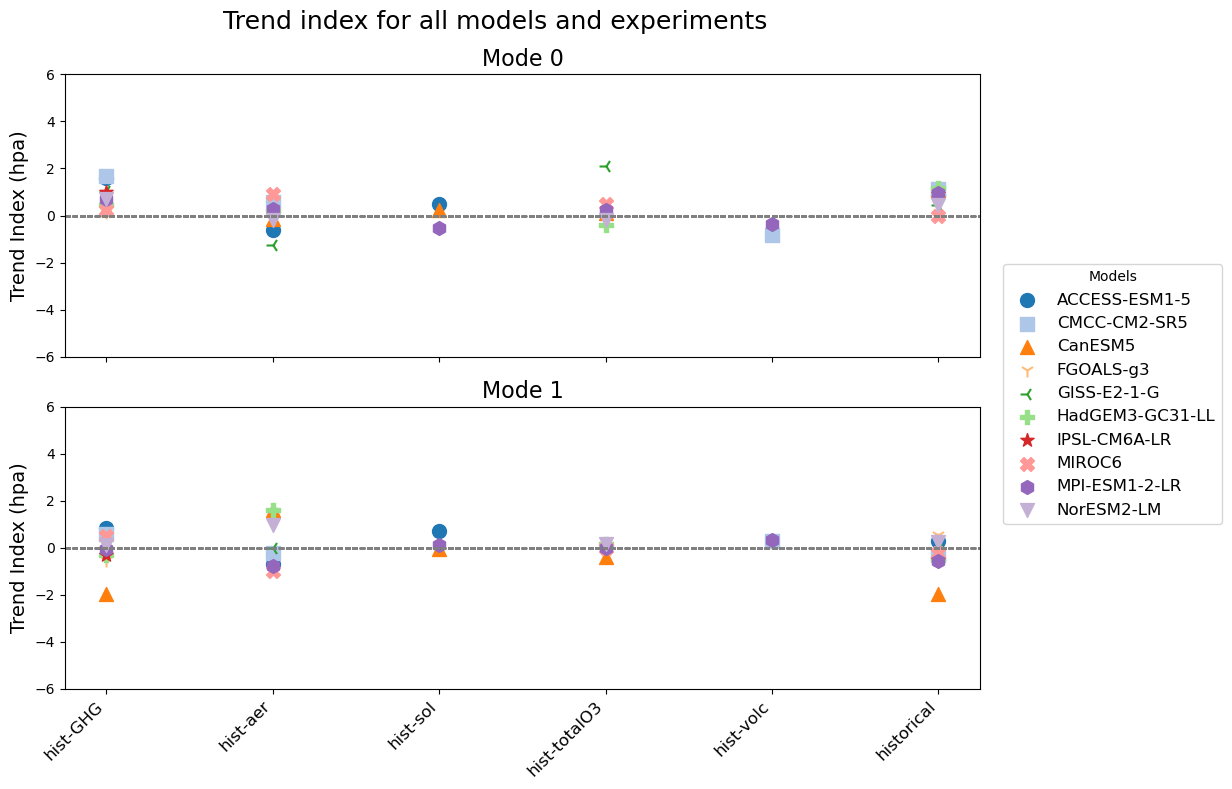

dict_keys(['hist-GHG', 'hist-aer', 'hist-sol', 'hist-totalO3', 'hist-volc', 'historical'])
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/ACCESS-ESM1-5/psl_mon_historical_ACCESS-ESM1-5_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/CMCC-CM2-SR5/psl_mon_historical_CMCC-CM2-SR5_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/CanESM5/psl_mon_historical_CanESM5_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/FGOALS-g3/psl_mon_historical_FGOALS-g3_DJF_EOF_mean_1850-2014.nc
loading the existing EOF model mean from: /gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised_aligned/GISS-E2-1-G/psl_mon_historical_GISS-E2-1-G_DJF_EOF_mean_185

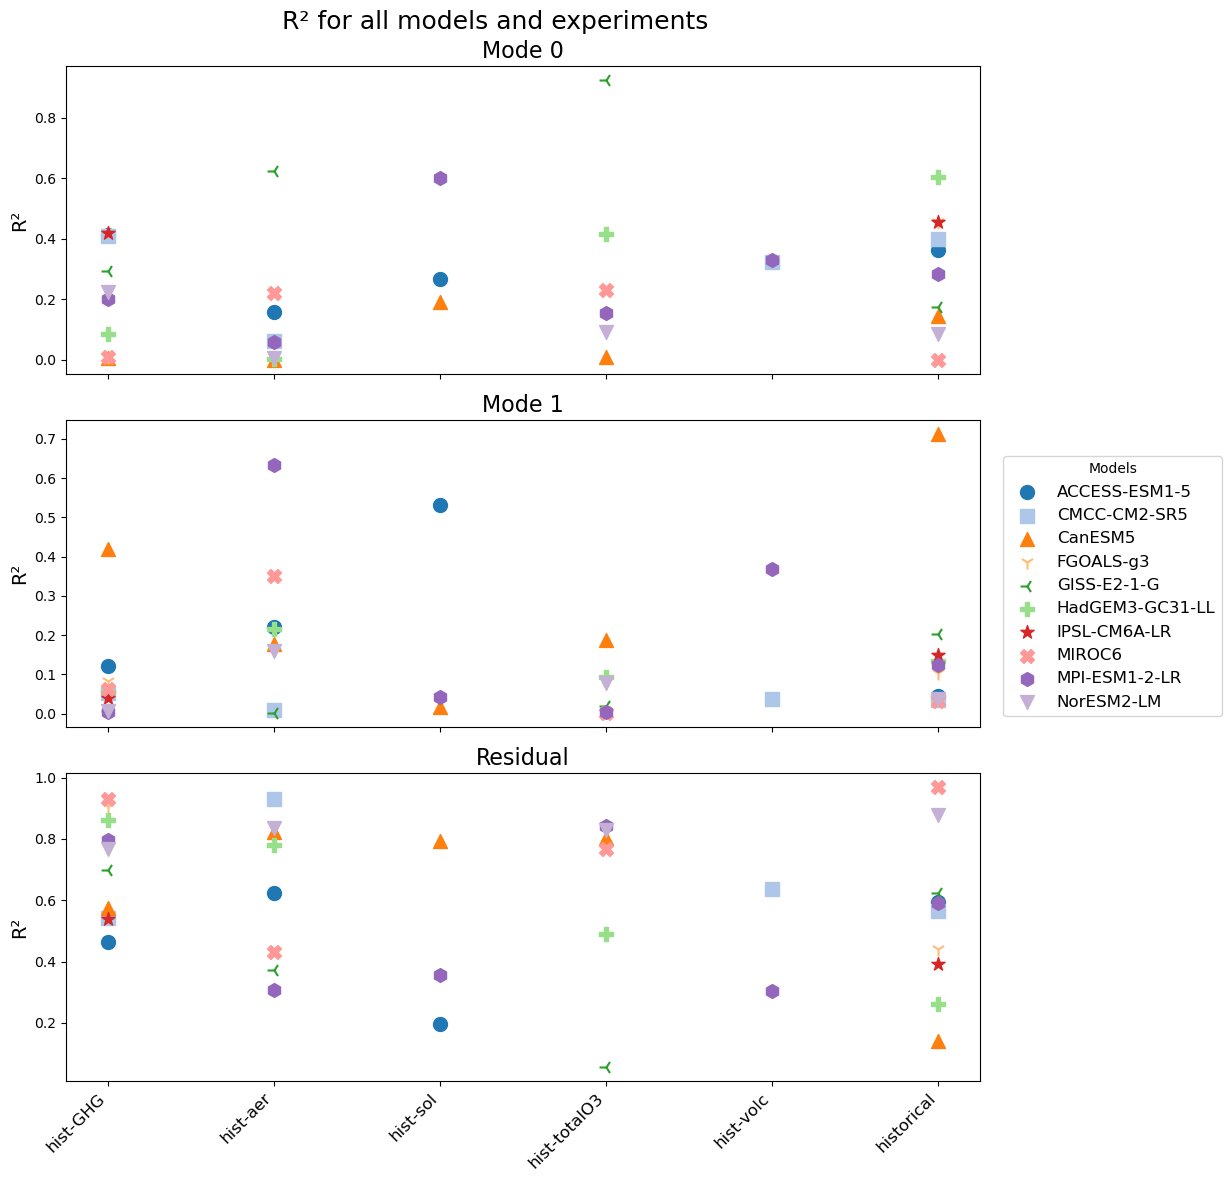

In [30]:
all_data = AllDataComparisons(
    folder=Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/"),
    output_dir=Path("/gws/nopw/j04/extant/users/slbennie/"),
    #obs_path=Path("/gws/nopw/j04/leader_epesc/era5/era5.194001-202406.nc")
)

all_data.set_time_bounds_all(1850, 2014)
all_data.set_domain(lat_bounds=(20,80), lon_bounds=(-90,40))
all_data.set_season([12,1,2])
all_data.set_variable('psl')


#all_data.experiments["historical"].calc_amplitude_all_models(2)


#all_data.experiments["historical"].plot_linear_trend_all_models()


#all_data.experiments['historical'].plot_EOF_all_models(2)

#era5 = all_data.experiments["historical"].models["era5"].members["ensemble1"]
#Had = all_data.experiments["historical"].models["HadGEM3-GC31-LL"].members["r11i1p1f3"]

#era5.calc_EOF_per_ensemble(2)
#Had.calc_EOF_per_ensemble(2)

#ACC = all_data.experiments["historical"].models['ACCESS-ESM1-5'].members['r5i1p1f1']
#ds = ACC.calc_EOF_mean(2)
#ds = ACC.calc_EOF_per_ensemble(2)
#ds = ACC.calc_EOF_per_ensemble(2)
#ds

#era5_member = era5.members["ensemble1"]
#era5_member.select_data()

#historical = all_data.experiments['historical'].calc_EOF_concat_all_models(2)
#historical_EOFs = all_data.experiments['historical'].calc_EOF_indiv_all_models(2)
#historical_EOFs = all_data.experiments['historical'].calc_EOF_mean_all_models(2)
#all_data.experiments['historical'].models['HadGEM3-GC31-LL'].calc_seas_anomalies_all_members('psl')

# Access just like any other model
#era5 = all_data.experiments["historical"].models["era5"]
#era5_member = era5.members["ensemble1"]
#era5_member.calc_EOF_per_ensemble('psl',2)
#all_data.projection_steps_plot(2)
index = all_data.projection_index_plot_filtered(2)
all_data.R2_plot_filtered(2)
#era5_member.calc_seas_anomaly(Path('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/era5/psl_mon_historical_era5_ensemble1_DJF_anomaly.nc'),'psl')

In [15]:
def NAtlantic_check_EOF(eof: xr.DataArray, max_modes:int) -> xr.DataArray:
    """
    Checks that the EOF is aligned as standard for the North Atlantic
    """
    eof_aligned = eof.copy()

    for n in range(max_modes):
        mode = eof_aligned.sel(mode=n)

        if n == 0:
            ref = mode.sel(lat=65, lon=-20, method='nearest')
            if ref.values > 0:
                eof_aligned.loc[dict(mode=n)] = -mode

        if n ==1:
            ref = mode.sel(lat=40, lon=-10, method='nearest')
            if ref.values < 0:
                eof_aligned.loc[dict(mode=n)] = -mode            
    
    return eof_aligned
models = ['ACCESS-ESM1-5','CanESM5', 'CMCC-CM2-SR5', 'FGOALS-g3', 'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-LR', 'NorESM2-LM']

for i in models:
    ds = xr.open_dataset(f'/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised/{i}/psl_mon_historical_{i}_DJF_EOF_mean_1940-2014.nc')
    # Apply alignment to EOFs (assuming variable name is 'eofs')
    eof = NAtlantic_check_EOF(ds['eofs'], max_modes=2)
    
    # === Plot comparison ===
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ds['eofs'].sel(mode=0).plot(ax=axes[0,0])
    axes[0,0].set_title("Original EOF Mode 0 (NAO-like)")
    eof.sel(mode=0).plot(ax=axes[0,1])
    axes[0,1].set_title("Corrected EOF Mode 0")
    
    ds['eofs'].sel(mode=1).plot(ax=axes[1,0])
    axes[1,0].set_title("Original EOF Mode 1 (EA-like)")
    eof.sel(mode=1).plot(ax=axes[1,1])
    axes[1,1].set_title("Corrected EOF Mode 1")
    
    plt.tight_layout()
    plt.show()

KeyboardInterrupt: 

In [ ]:
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised/ACCESS-ESM1-5/psl_mon_historical_ACCESS-ESM1-5_DJF_EOF_mean_1850-2014.nc')
ds['eofs'].sel(mode=1).plot()
plt.show()

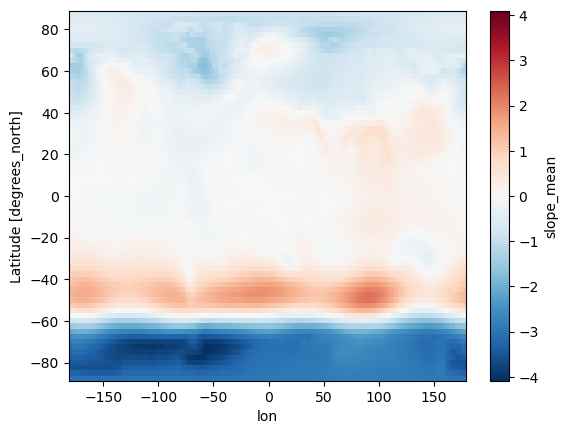

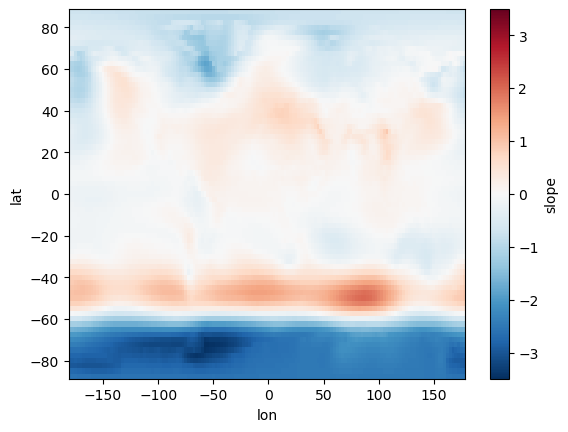

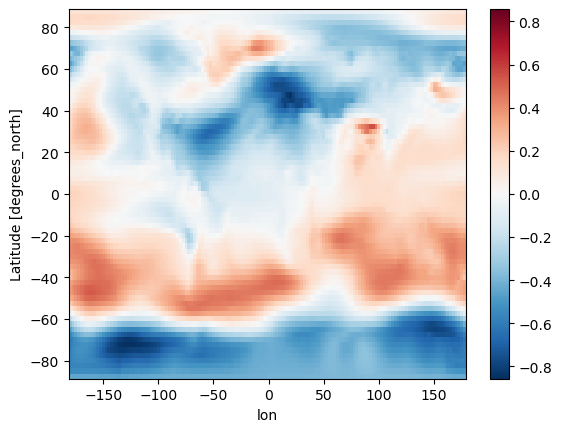

In [86]:
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/global/historical/ACCESS-ESM1-5/psl_mon_historical_ACCESS-ESM1-5_DJF_mean_ens_linear_trend_stats_1940-2014.nc')
ds['slope_mean'].plot()
plt.show()

ds2 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/global/historical/ACCESS-ESM1-5/psl_mon_historical_ACCESS-ESM1-5_DJF_linear_trend_stats_1850-2014.nc')
ds2['slope'].plot()
plt.show()

diff = ds['slope_mean']-ds2['slope']
diff.plot()
plt.show()

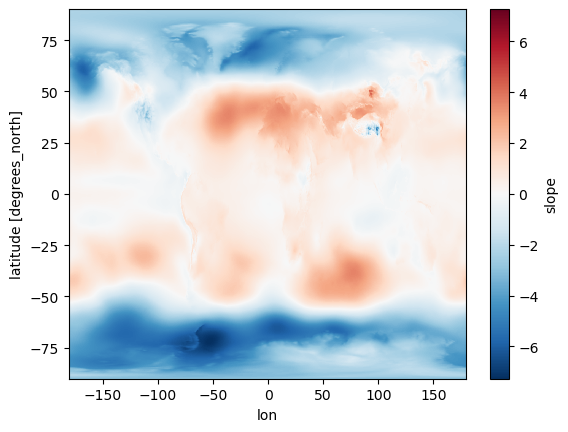

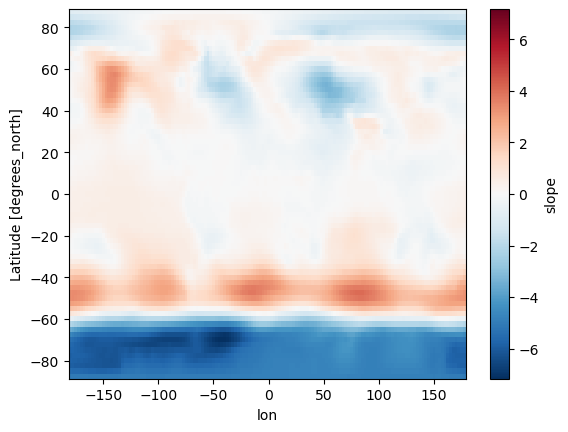

In [89]:
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/global/historical/era5/psl_mon_historical_era5_ensemble1_DJF_linear_trend_stats_1940-2014.nc')
ds['slope'].plot()
plt.show()

ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/trend_calc_LESFMIP/linear_regression/global/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r60i1p1f3_DJF_linear_trend_stats_1940-2014.nc')
ds['slope'].plot()
plt.show()

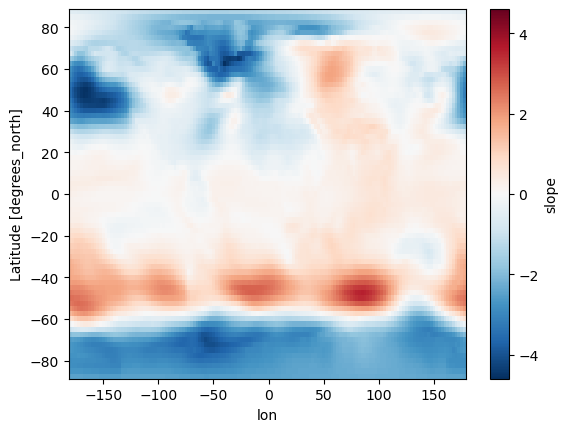

In [38]:
ACC['slope'].plot()
plt.show()

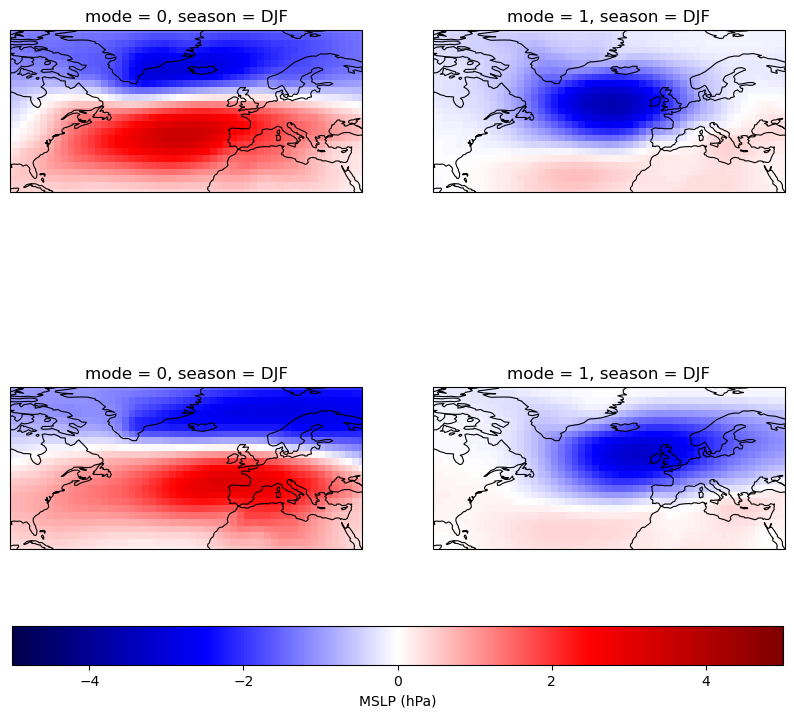

In [36]:
# Open datasets
Had = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_mean_1850-2014.nc')['eofs']
Can = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/normalised/CanESM5/psl_mon_historical_CanESM5_DJF_EOF_mean_1850-2014.nc')['eofs']

vmin = -5
vmax = 5
cmap = 'seismic'

# Use PlateCarree projection for lat/lon data
proj = ccrs.PlateCarree()

fig, axes = plt.subplots(2, 2, figsize=(10, 10),
                         subplot_kw={'projection': proj})

# Plot with shared vmin/vmax
im1 = (-Had.sel(mode=0)).plot(ax=axes[0,0], transform=proj, vmin=vmin, vmax=vmax,
                              add_colorbar=False, cmap=cmap)
im2 = (Had.sel(mode=1)).plot(ax=axes[0,1], transform=proj, vmin=vmin, vmax=vmax,
                             add_colorbar=False, cmap=cmap)
im3 = (Can.sel(mode=0)).plot(ax=axes[1,0], transform=proj, vmin=vmin, vmax=vmax,
                             add_colorbar=False, cmap=cmap)
im4 = (-Can.sel(mode=1)).plot(ax=axes[1,1], transform=proj, vmin=vmin, vmax=vmax,
                              add_colorbar=False, cmap=cmap)

# Add coastlines and extent to each map
for ax in axes.flat:
    ax.coastlines(resolution='110m', color='black', linewidth=0.8)
    ax.set_extent([-90, 40, 20, 80], crs=proj)

# Add one shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("MSLP (hPa)")
plt.tight_layout

plt.show()

ValueError: x and y must have same first dimension, but have shapes (71,) and (165, 71, 144)

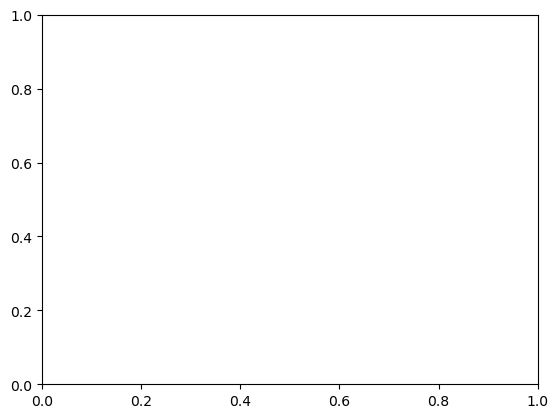

In [17]:
ds = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/ACCESS-ESM1-5/psl_mon_historical_ACCESS-ESM1-5_r5i1p1f1_DJF_anomaly_1850-2014.nc')
anomaly_mean_lat = ds['psl'].mean(dim=('year','lon'))
#print(anomaly_mean_lat)
anomaly = ds['psl']

lat = anomaly['lat']
coslat = np.cos(np.deg2rad(lat))

plt.figure()
plt.plot(lat, anomaly, label='Your anomaly')
plt.plot(lat, coslat / coslat.max() * anomaly.max(), '--', label='cos(lat) scaled')
plt.legend()
plt.title('Check if anomalies scale like cos(lat)')
plt.show()


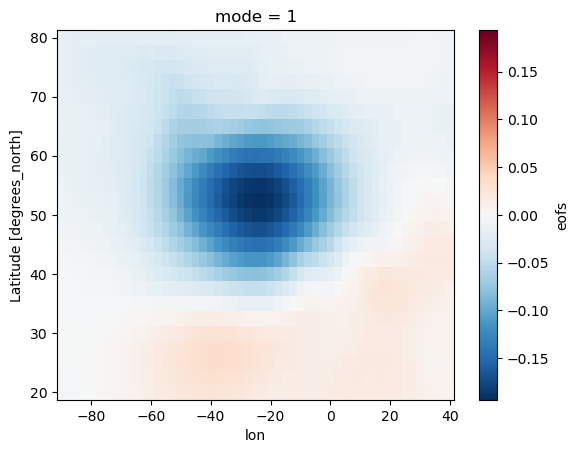

In [4]:
HadGEM3_mean = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_mean_1850-2014.nc')
HadGEM3_mean = HadGEM3_mean['eofs'].sel(mode=1)*-1
HadGEM3_concat = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_concat_1850-2014.nc')
HadGEM3_concat = HadGEM3_concat['eofs'].sel(mode=1)
HadGEM3_diff = HadGEM3_concat - HadGEM3_mean
HadGEM3_diff.plot()

<xarray.Dataset> Size: 293kB
Dimensions:             (TIME: 165, lat: 71, lon: 144)
Coordinates:
  * TIME                (TIME) int32 660B 1850 1851 1852 1853 ... 2012 2013 2014
  * lat                 (lat) float64 568B -87.5 -85.0 -82.5 ... 82.5 85.0 87.5
  * lon                 (lon) float64 1kB -180.0 -177.5 -175.0 ... 175.0 177.5
Data variables: (12/14)
    nao_pattern_ann     (lat, lon) float32 41kB ...
    nao_pattern_djf     (lat, lon) float32 41kB ...
    nao_pattern_jas     (lat, lon) float32 41kB ...
    nao_pattern_jfm     (lat, lon) float32 41kB ...
    nao_pattern_jja     (lat, lon) float32 41kB ...
    nao_pattern_mam     (lat, lon) float32 41kB ...
    ...                  ...
    nao_timeseries_djf  (TIME) float32 660B ...
    nao_timeseries_jas  (TIME) float32 660B ...
    nao_timeseries_jfm  (TIME) float32 660B ...
    nao_timeseries_jja  (TIME) float32 660B ...
    nao_timeseries_mam  (TIME) float32 660B ...
    nao_timeseries_son  (TIME) float32 660B ...
Attributes

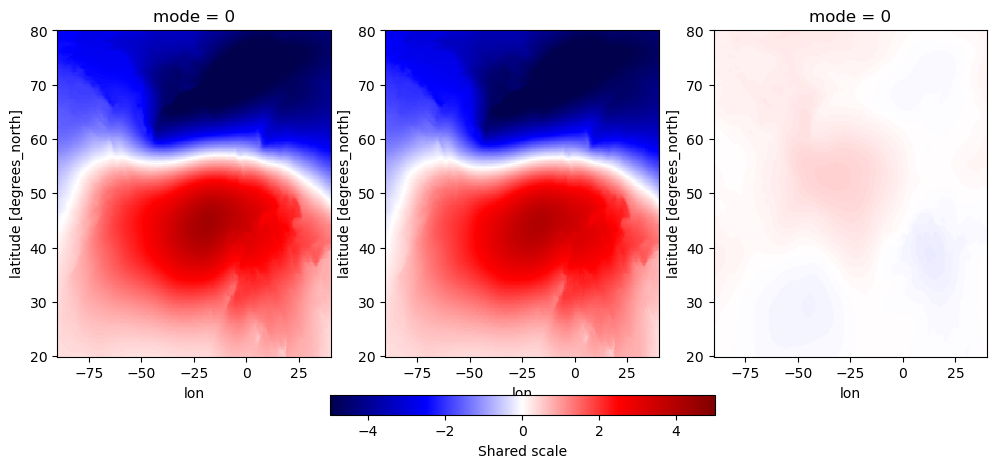

In [43]:
max_modes=1
era5_anom = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/era5/psl_mon_historical_era5_ensemble1_DJF_anomaly_1940-2014.nc')['psl']
era5_anom = era5_anom.sel(lat=slice(20,80), lon=slice(-90,40))
era5_anom = era5_anom.rename({'year': 'time'})
era5_anom = era5_anom / 100

anomaly_trans = era5_anom.transpose('time', 'lat', 'lon')

coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[...,np.newaxis]

solver = Eof(anomaly_trans, weights=wgts)
EOF0 = solver.eofs(neofs=max_modes)

eigs = solver.eigenvalues(neigs=max_modes)
eigs_np = np.sqrt(eigs.values)  # convert to NumPy
EOF_phys_era5 = EOF0 * eigs_np[:, np.newaxis, np.newaxis]

# 4. Get PCs with unit variance (dimensionless indices)
#pcs_norm = solver.pcs(npcs=max_modes, pcscaling=2)

pc = solver.pcs(npcs=max_modes, pcscaling=1).sel(mode=0)

regression_map = (anomaly_trans * pc).mean(dim='time')

CVDP_era5 = EnsembleMemberCalculations(
    data_path=Path('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/ERA5_1.cvdp_data.1940-2014.nc'),
    #model='era5',
    member_id='ensemble1'
)

CVDP_era5.load_data()
print(era5_CVDP)
era5_CVDP = CVDP_era5.normalise_era5()
era5_CVDP_plot = era5_CVDP['nao_pattern_djf'].sel(lat=slice(20,80), lon=slice(-90,40))
print(era5_CVDP_plot)
print(era5_CVDP.lon.min().values, era5_CVDP.lon.max().values)


cmap='seismic'

# Find common vmin/vmax across both datasets
vmin = -5#min(regression_map.min().min(), era5_CVDP_plot.min().min())
vmax = 5#max(regression_map.max().max(), era5_CVDP_plot.max().max())

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot with shared vmin/vmax
im1 = regression_map.plot(ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im2 = era5_CVDP_plot.plot(ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im3 = (regression_map - era5_CVDP_plot).plot(ax=axes[2], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)


# Add one shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Shared scale")

plt.show()

0.9939393939393939 0.02163425926040437 -0.017665246211388316
normalising era5
<xarray.Dataset> Size: 293kB
Dimensions:             (TIME: 165, lat: 71, lon: 144)
Coordinates:
  * TIME                (TIME) int32 660B 1850 1851 1852 1853 ... 2012 2013 2014
  * lat                 (lat) float64 568B -87.5 -85.0 -82.5 ... 82.5 85.0 87.5
  * lon                 (lon) float64 1kB -180.0 -177.5 -175.0 ... 175.0 177.5
Data variables: (12/14)
    nao_pattern_ann     (lat, lon) float32 41kB ...
    nao_pattern_djf     (lat, lon) float32 41kB ...
    nao_pattern_jas     (lat, lon) float32 41kB ...
    nao_pattern_jfm     (lat, lon) float32 41kB ...
    nao_pattern_jja     (lat, lon) float32 41kB ...
    nao_pattern_mam     (lat, lon) float32 41kB ...
    ...                  ...
    nao_timeseries_djf  (TIME) float32 660B ...
    nao_timeseries_jas  (TIME) float32 660B ...
    nao_timeseries_jfm  (TIME) float32 660B ...
    nao_timeseries_jja  (TIME) float32 660B ...
    nao_timeseries_mam  (TIM

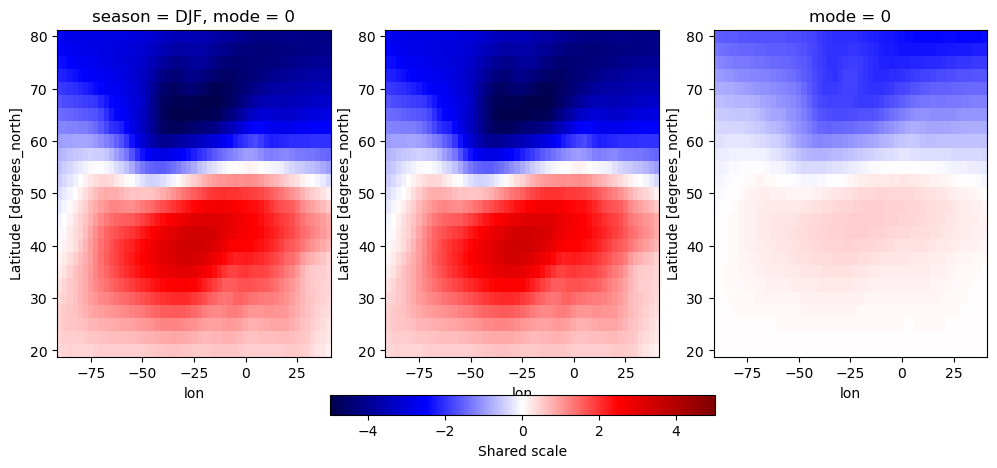

NameError: name 'EOF' is not defined

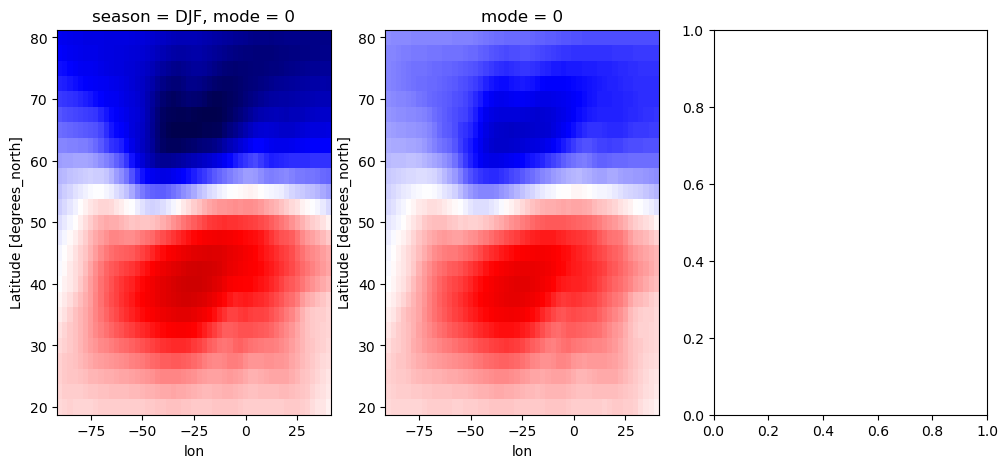

In [73]:
max_modes=1
era5_anom = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r52i1p1f3_DJF_anomaly_1850-2014.nc')['psl']
era5_anom = era5_anom.sel(lat=slice(20,80), lon=slice(-90,40))
era5_anom = era5_anom.rename({'year': 'time'})
era5_anom = era5_anom / 100

anomaly_trans = era5_anom.transpose('time', 'lat', 'lon')

coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[...,np.newaxis]

solver = Eof(anomaly_trans, weights=wgts)
EOF0 = solver.eofs(neofs=max_modes)

eigs = solver.eigenvalues(neigs=max_modes)
eigs_np = np.sqrt(eigs.values)  # convert to NumPy
EOF_phys_era5 = EOF0 * eigs_np[:, np.newaxis, np.newaxis]

# 4. Get PCs with unit variance (dimensionless indices)
#pcs_norm = solver.pcs(npcs=max_modes, pcscaling=2)

pc = solver.pcs(npcs=max_modes, pcscaling=1).sel(mode=0)
mean_field = anomaly_trans.mean(dim='time')
print(float(np.var(pc, ddof=0)), mean_field.max().item(), mean_field.min().item())


#regression_map = (anomaly_trans * pc).mean(dim='time')
top = (anomaly_trans * pc).sum(dim='time')
bottom = (pc**2).sum(dim='time')
regression_map = top / (bottom)# * wgts)

CVDP_era5 = EnsembleMemberCalculations(
    data_path=Path('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_r52i1p1f3.cvdp_data.1850-2014.nc'),
    #model='era5',
    member_id='ensemble1'
)

CVDP_era5.load_data()
era5_CVDP = CVDP_era5.normalise_era5()
era5_CVDP_plot = era5_CVDP['nao_pattern_djf'].sel(lat=slice(20,80), lon=slice(-90,40))

cmap='seismic'

# Find common vmin/vmax across both datasets
vmin = -5#min(regression_map.min().min(), era5_CVDP_plot.min().min())
vmax = 5#max(regression_map.max().max(), era5_CVDP_plot.max().max())

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot with shared vmin/vmax
im1 = (-regression_map).plot(ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im2 = era5_CVDP_plot.plot(ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im3 = (EOF_phys_era5 + era5_CVDP_plot).plot(ax=axes[2], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)


# Add one shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Shared scale")

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot with shared vmin/vmax
im1 = (-regression_map).plot(ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im2 = (-EOF_phys_era5).plot(ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im3 = (EOF-regression_map).plot(ax=axes[2], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)


# Add one shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Shared scale")

plt.show()

max abs diff: 0.018439948496757452
EOF range: -3.0425915019647625 3.2855539031381236
regression range: -3.024151553468005 3.2656414552403192
pc mean, std: -4.306319610667274e-17 0.9969650916353059
corr between projection and pc: 0.9967617880465431


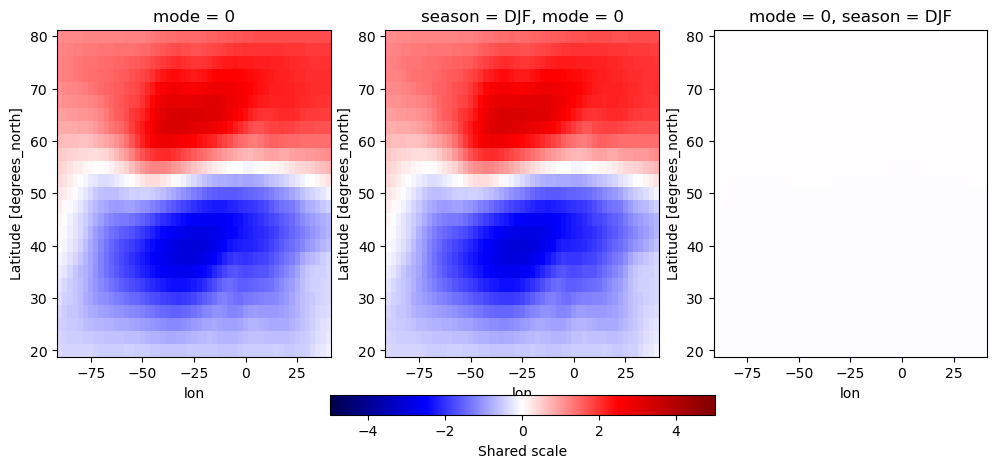

<xarray.DataArray (mode: 1)> Size: 8B
array([1.])
Coordinates:
  * mode     (mode) int64 8B 0


In [5]:
max_modes=1
era5_anom = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r52i1p1f3_DJF_anomaly_1850-2014.nc')['psl']
era5_anom = era5_anom.sel(lat=slice(20,80), lon=slice(-90,40))
era5_anom = era5_anom.rename({'year': 'time'})
era5_anom = era5_anom / 100

anomaly_trans = era5_anom.transpose('time', 'lat', 'lon')

coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[...,np.newaxis]

# --- EOF solver ---
solver = Eof(anomaly_trans, weights=wgts)

# --- EOFs and PCs ---
EOF_unit = solver.eofs(neofs=max_modes)
eigs = solver.eigenvalues(neigs=max_modes)
EOF_phys = EOF_unit * np.sqrt(eigs.values)[:, np.newaxis, np.newaxis] #/ wgts

pc = solver.pcs(npcs=max_modes, pcscaling=1).sel(mode=0)

# --- Demean before regression ---
anomaly_trans = anomaly_trans - anomaly_trans.mean(dim='time')
pc = pc - pc.mean(dim='time')

# --- Regression (OLS) ---
regression_map = (anomaly_trans * pc).mean(dim='time', skipna=True)*wgts
scale = pc.std(dim='time', ddof=0)
#regression_map = regression_map / scale

# --- Compare ---
diff = regression_map - EOF_phys[0]
print('max abs diff:', float(diff.max()))
print('EOF range:', float(EOF_phys[0].min()), float(EOF_phys[0].max()))
print('regression range:', float(regression_map.min()), float(regression_map.max()))

print('pc mean, std:', float(pc.mean()), float(pc.std(ddof=0)))
corr = xr.corr(anomaly_trans.dot(EOF_phys[0]), pc, dim='time')
print('corr between projection and pc:', float(corr))

cmap='seismic'

# Find common vmin/vmax across both datasets
vmin = -5#min(regression_map.min().min(), era5_CVDP_plot.min().min())
vmax = 5#max(regression_map.max().max(), era5_CVDP_plot.max().max())

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot with shared vmin/vmax
im1 = (EOF_phys).plot(ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im2 = (regression_map).plot(ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im3 = (EOF_phys-regression_map).plot(ax=axes[2], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)


# Add one shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Shared scale")

plt.show()

pattern_corr = []
for m in EOF_phys.mode:
    # Flatten the spatial dimensions
    phys = EOF_phys.sel(mode=m).stack(spatial=('lat', 'lon'))
    unit = EOF_unit.sel(mode=m).stack(spatial=('lat', 'lon'))
    
    # Remove NaNs if present
    mask = np.isfinite(phys) & np.isfinite(unit)
    corr = np.corrcoef(phys.values[mask], unit.values[mask])[0, 1]
    pattern_corr.append(corr)

pattern_corr = xr.DataArray(pattern_corr, dims=['mode'], coords={'mode': EOF_phys.mode})
print(pattern_corr)


normalising era5
<xarray.Dataset> Size: 293kB
Dimensions:             (TIME: 165, lat: 71, lon: 144)
Coordinates:
  * TIME                (TIME) int32 660B 1850 1851 1852 1853 ... 2012 2013 2014
  * lat                 (lat) float64 568B -87.5 -85.0 -82.5 ... 82.5 85.0 87.5
  * lon                 (lon) float64 1kB -180.0 -177.5 -175.0 ... 175.0 177.5
Data variables: (12/14)
    nao_pattern_ann     (lat, lon) float32 41kB ...
    nao_pattern_djf     (lat, lon) float32 41kB ...
    nao_pattern_jas     (lat, lon) float32 41kB ...
    nao_pattern_jfm     (lat, lon) float32 41kB ...
    nao_pattern_jja     (lat, lon) float32 41kB ...
    nao_pattern_mam     (lat, lon) float32 41kB ...
    ...                  ...
    nao_timeseries_djf  (TIME) float32 660B ...
    nao_timeseries_jas  (TIME) float32 660B ...
    nao_timeseries_jfm  (TIME) float32 660B ...
    nao_timeseries_jja  (TIME) float32 660B ...
    nao_timeseries_mam  (TIME) float32 660B ...
    nao_timeseries_son  (TIME) float32 66

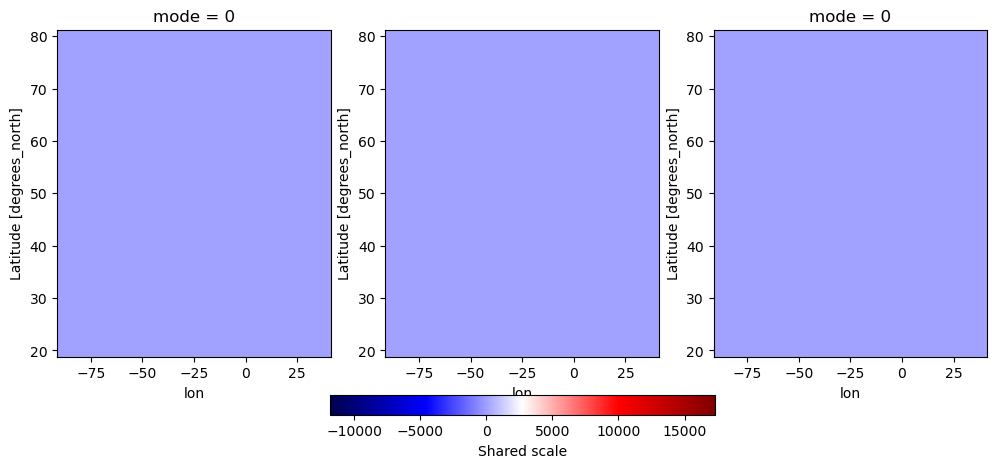

In [35]:
max_modes=1
era5_anom = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r52i1p1f3_DJF_anomaly_1850-2014.nc')['psl']
era5_anom = era5_anom.sel(lat=slice(20,80), lon=slice(-90,40))
era5_anom = era5_anom.rename({'year': 'time'})
era5_anom = era5_anom / 100

anomaly_trans = era5_anom.transpose('time', 'lat', 'lon')

coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[...,np.newaxis]

solver = Eof(anomaly_trans, weights=wgts)
EOF0 = solver.eofs(neofs=max_modes)

eigs = solver.eigenvalues(neigs=max_modes)
eigs_np = np.sqrt(eigs.values)  # convert to NumPy
EOF_phys_era5 = EOF0 * eigs_np[:, np.newaxis, np.newaxis]

# 4. Get PCs with unit variance (dimensionless indices)
#pcs_norm = solver.pcs(npcs=max_modes, pcscaling=2)

pc = solver.pcs(npcs=max_modes, pcscaling=2).sel(mode=0)

regression_map = (anomaly_trans * pc).mean(dim='time')

CVDP_era5 = EnsembleMemberCalculations(
    data_path=Path('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_r52i1p1f3.cvdp_data.1850-2014.nc'),
    #model='era5',
    member_id='ensemble1'
)

CVDP_era5.load_data()
era5_CVDP = CVDP_era5.normalise_era5()
era5_CVDP_plot = era5_CVDP['nao_pattern_djf'].sel(lat=slice(20,80), lon=slice(-90,40))

cmap='seismic'

# Find common vmin/vmax across both datasets
vmin = min(regression_map.min().min(), era5_CVDP_plot.min().min())
vmax = max(regression_map.max().max(), era5_CVDP_plot.max().max())

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot with shared vmin/vmax
im1 = (EOF_phys_era5).plot(ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im2 = era5_CVDP_plot.plot(ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im3 = (EOF_phys_era5 - era5_CVDP_plot).plot(ax=axes[2], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)


# Add one shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Shared scale")

plt.show()

normalising era5
<xarray.Dataset> Size: 29MB
Dimensions:             (TIME: 75, lat: 721, lon: 1440)
Coordinates:
  * TIME                (TIME) int32 300B 1940 1941 1942 1943 ... 2012 2013 2014
  * lat                 (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon                 (lon) float32 6kB -180.8 -180.5 -180.2 ... 178.8 179.0
Data variables: (12/14)
    nao_pattern_ann     (lat, lon) float32 4MB ...
    nao_pattern_djf     (lat, lon) float32 4MB ...
    nao_pattern_jas     (lat, lon) float32 4MB ...
    nao_pattern_jfm     (lat, lon) float32 4MB ...
    nao_pattern_jja     (lat, lon) float32 4MB ...
    nao_pattern_mam     (lat, lon) float32 4MB ...
    ...                  ...
    nao_timeseries_djf  (TIME) float32 300B ...
    nao_timeseries_jas  (TIME) float32 300B ...
    nao_timeseries_jfm  (TIME) float32 300B ...
    nao_timeseries_jja  (TIME) float32 300B ...
    nao_timeseries_mam  (TIME) float32 300B ...
    nao_timeseries_son  (TIME) float32 300B ..

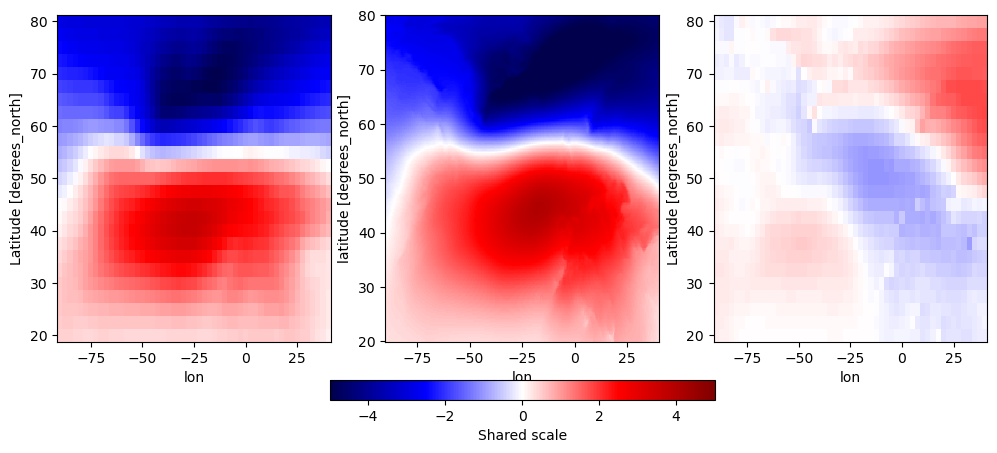

In [50]:
CVDP_era5 = EnsembleMemberCalculations(
    data_path=Path('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/ERA5_1.cvdp_data.1940-2014.nc'),
    #model='era5',
    member_id='ensemble1'
)

CVDP_era5.load_data()
era5_CVDP = CVDP_era5.normalise_era5()
era5_CVDP_plot = era5_CVDP['nao_pattern_djf'].sel(lat=slice(20,80), lon=slice(-90,40))

CVDP_had = EnsembleMemberCalculations(
    data_path=Path('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_r60i1p1f3.cvdp_data.1850-2014.nc'),
    #model='era5',
    member_id='ensemble1'
)

CVDP_had.load_data()
had_CVDP = CVDP_had.normalise_era5()
had_CVDP_plot = had_CVDP['nao_pattern_djf'].sel(lat=slice(20,80), lon=slice(-90,40))

cmap='seismic'

# Find common vmin/vmax across both datasets
vmin = -5#min(regression_map.min().min(), era5_CVDP_plot.min().min())
vmax = 5#max(regression_map.max().max(), era5_CVDP_plot.max().max())

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot with shared vmin/vmax
im1 = had_CVDP_plot.plot(ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im2 = era5_CVDP_plot.plot(ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)
im3 = (had_CVDP_plot - era5_CVDP_plot).plot(ax=axes[2], vmin=vmin, vmax=vmax, add_colorbar=False, cmap=cmap)


# Add one shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Shared scale")

plt.show()

normalising era5
<xarray.Dataset> Size: 293kB
Dimensions:             (TIME: 165, lat: 71, lon: 144)
Coordinates:
  * TIME                (TIME) int32 660B 1850 1851 1852 1853 ... 2012 2013 2014
  * lat                 (lat) float64 568B -87.5 -85.0 -82.5 ... 82.5 85.0 87.5
  * lon                 (lon) float64 1kB -180.0 -177.5 -175.0 ... 175.0 177.5
Data variables: (12/14)
    nao_pattern_ann     (lat, lon) float32 41kB ...
    nao_pattern_djf     (lat, lon) float32 41kB ...
    nao_pattern_jas     (lat, lon) float32 41kB ...
    nao_pattern_jfm     (lat, lon) float32 41kB ...
    nao_pattern_jja     (lat, lon) float32 41kB ...
    nao_pattern_mam     (lat, lon) float32 41kB ...
    ...                  ...
    nao_timeseries_djf  (TIME) float32 660B ...
    nao_timeseries_jas  (TIME) float32 660B ...
    nao_timeseries_jfm  (TIME) float32 660B ...
    nao_timeseries_jja  (TIME) float32 660B ...
    nao_timeseries_mam  (TIME) float32 660B ...
    nao_timeseries_son  (TIME) float32 66

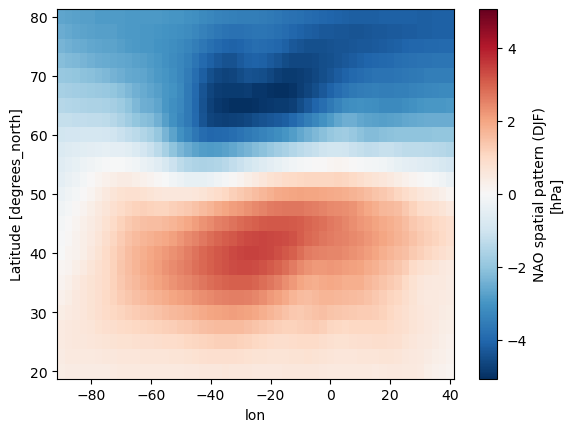

Variance explained (%): [42.52199877]
EOF_phys units: hPa, pcs_norm units: dimensionless


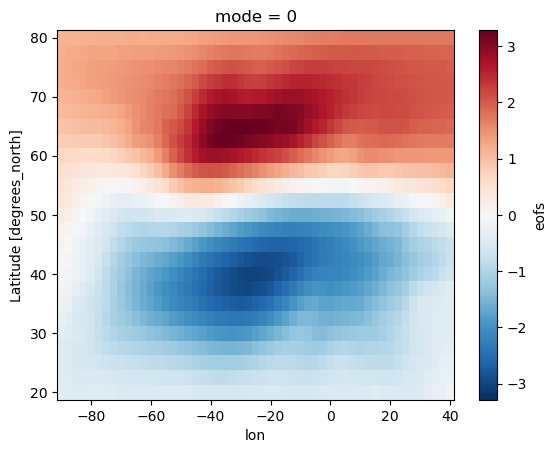

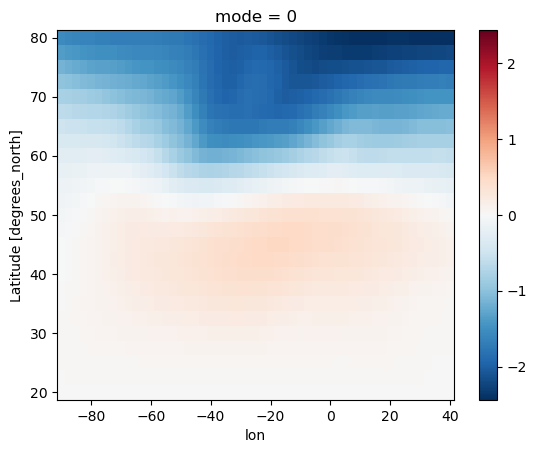

In [9]:
CVDP_Had = EnsembleMemberCalculations(
    data_path=Path('/gws/nopw/j04/extant/users/slbennie/CVDP_outputs/NAO/historical/historical_NAO/HadGEM3-GC31-LL_r52i1p1f3.cvdp_data.1850-2014.nc'),
    #model='era5',
    member_id='ensemble1'
)

CVDP_Had.load_data()
Had_CVDP = CVDP_Had.normalise_era5()

#print(norm['nao_pattern_djf'])
Had_CVDP['nao_pattern_djf'].sel(lat=slice(20,80), lon=slice(-90,40)).plot()
plt.show()

max_modes=1
had_anom = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r52i1p1f3_DJF_anomaly_1850-2014.nc')['psl']
had_anom = had_anom.sel(lat=slice(20,80), lon=slice(-90,40))
had_anom = had_anom.rename({'year': 'time'})
had_anom = had_anom / 100

anomaly_trans = had_anom.transpose('time', 'lat', 'lon')

coslat = np.cos(np.deg2rad(anomaly_trans.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)[...,np.newaxis]

solver = Eof(anomaly_trans, weights=wgts)
EOF0 = solver.eofs(neofs=max_modes)

eigs = solver.eigenvalues(neigs=max_modes)
eigs_np = np.sqrt(eigs.values)  # convert to NumPy
EOF_phys = EOF0 * eigs_np[:, np.newaxis, np.newaxis]

# 4. Get PCs with unit variance (dimensionless indices)
pcs_norm = solver.pcs(npcs=max_modes, pcscaling=2)

# 5. Variance explained (same regardless of scaling)
varfrac = solver.varianceFraction(neigs=max_modes) * 100

print("Variance explained (%):", varfrac.values)
print("EOF_phys units: hPa, pcs_norm units: dimensionless")

EOF_phys.plot()
plt.show()

diff = (Had_CVDP['nao_pattern_djf']+EOF_phys)
diff.plot()
plt.show()

-0.1237787815071517 0.10746196369002825


/tmp/ipykernel_2815/1011441956.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


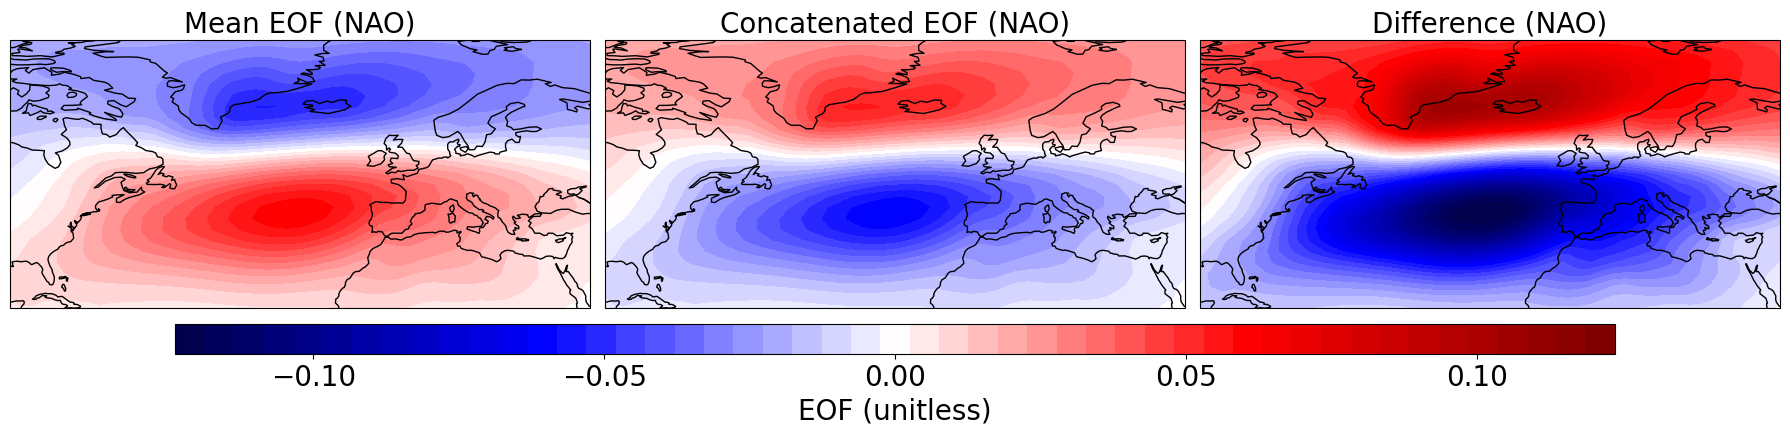

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr

# load data
HadGEM3_mean = xr.open_dataset(
    '/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_mean_1850-2014.nc'
)['eofs'].sel(mode=0) * -1

HadGEM3_concat = xr.open_dataset(
    '/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_DJF_EOF_concat_1850-2014.nc'
)['eofs'].sel(mode=0)

HadGEM3_diff = HadGEM3_concat - HadGEM3_mean

# pick consistent levels/norm
vmin = min(float(HadGEM3_mean.min()), float(HadGEM3_concat.min()), float(HadGEM3_diff.min()))
vmax = max(float(HadGEM3_mean.max()), float(HadGEM3_concat.max()), float(HadGEM3_diff.max()))
levels = np.linspace(vmin, -vmin, 50)
print(vmin,vmax)
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=-vmin)

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})

HadGEM3_mean.plot.contourf(
    ax=axes[0], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[0].set_title("Mean EOF (NAO)", fontsize=20)
axes[0].coastlines()

HadGEM3_concat.plot.contourf(
    ax=axes[1], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[1].set_title("Concatenated EOF (NAO)", fontsize=20)
axes[1].coastlines()

im = HadGEM3_diff.plot.contourf(
    ax=axes[2], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[2].set_title("Difference (NAO)", fontsize=20)
axes[2].coastlines()

# shared colorbar
ticks = [-0.1, -0.05, 0, 0.05, 0.1]
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.set_label("EOF (unitless)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()


<xarray.DataArray 'eofs' (lat: 25, lon: 53)> Size: 11kB
array([[ 0.00773517,  0.00834095,  0.0083451 , ...,  0.00266655,
         0.00226704,  0.00091503],
       [ 0.00850272,  0.00895673,  0.00919677, ...,  0.00367661,
         0.00267893,  0.00114429],
       [ 0.00888442,  0.00942325,  0.00973457, ...,  0.00400888,
         0.00221105,  0.0005715 ],
       ...,
       [-0.0142672 , -0.01460192, -0.01491805, ..., -0.02923872,
        -0.02922751, -0.02916575],
       [-0.0141704 , -0.01449143, -0.01478884, ..., -0.02609165,
        -0.02616279, -0.0261472 ],
       [-0.0133256 , -0.01360324, -0.01375414, ..., -0.0226435 ,
        -0.02266214, -0.02265349]])
Coordinates:
  * lat      (lat) float64 200B 20.0 22.5 25.0 27.5 30.0 ... 72.5 75.0 77.5 80.0
  * lon      (lon) float64 424B -90.0 -87.5 -85.0 -82.5 ... 32.5 35.0 37.5 40.0
    mode     int64 8B 0 <xarray.DataArray 'eofs' (lat: 25, lon: 53)> Size: 11kB
array([[ 0.00822369,  0.00885198,  0.00884993, ...,  0.00345853,
         0.0

/tmp/ipykernel_565/1338431717.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


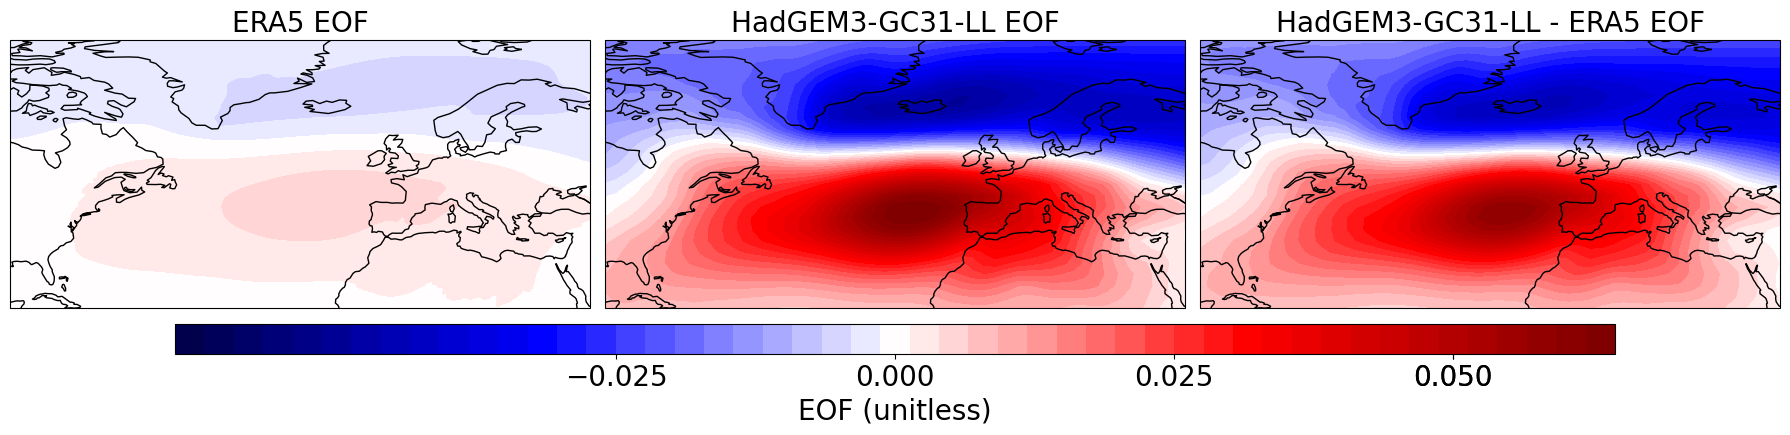

In [8]:
#era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/era5/psl_mon_historical_era5_ensemble1_DJF_EOF_indiv_1850-2014.nc')
#era5['eofs'].sel(mode=0).plot()
#plt.show()
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/era5/psl_mon_historical_era5_ensemble1_DJF_EOF_indiv_1940-2014.nc')
era5 = era5['eofs'].sel(mode=0)

model = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/EOF/historical/DJF/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r4i1p1f3_DJF_EOF_indiv_1940-2014.nc')
Had = (-1*model['eofs'].sel(mode=0))

diff = (Had - era5)
print(diff,Had)

# pick consistent levels/norm
vmin = min(float(Had.min()), float(era5.min()), float(diff.min()))
vmax = max(float(Had.max()), float(era5.max()), float(diff.max()))
maximum = max(-vmin,vmax)
levels = np.linspace(-maximum, maximum, 50)
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-maximum, vmax=maximum)

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})

era5.plot.contourf(
    ax=axes[0], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[0].set_title("ERA5 EOF", fontsize=20)
axes[0].coastlines()

Had.plot.contourf(
    ax=axes[1], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[1].set_title("HadGEM3-GC31-LL EOF", fontsize=20)
axes[1].coastlines()

im = diff.plot.contourf(
    ax=axes[2], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[2].set_title("HadGEM3-GC31-LL - ERA5 EOF", fontsize=20)
axes[2].coastlines()
print(maximum)

# shared colorbar
ticks = [0.05,-0.025,0,0.025,0.05]
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])

cbar = fig.colorbar(im, cax=cax, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.set_label("EOF (unitless)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()

13.117533406816365


/tmp/ipykernel_587/2463312324.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


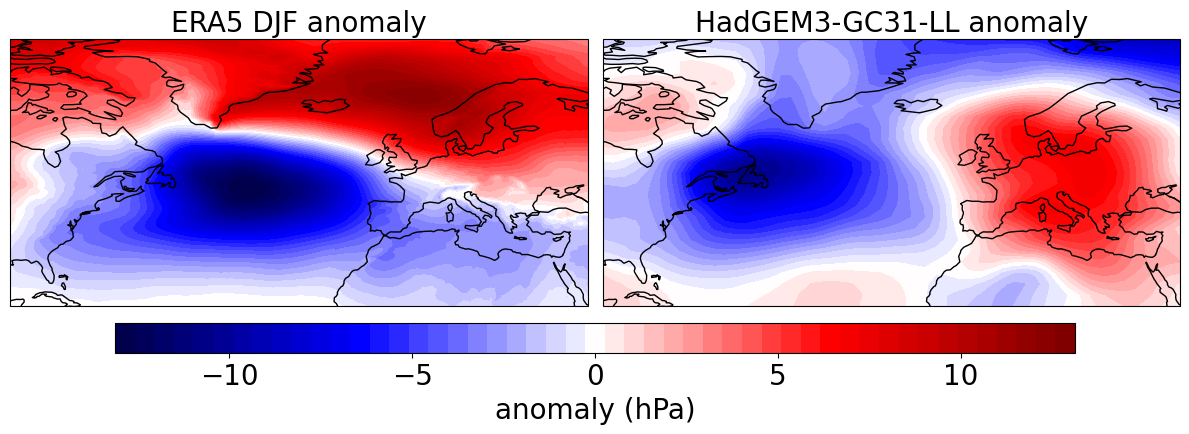

In [41]:
era5 = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/era5/psl_mon_historical_era5_ensemble1_DJF_anomaly_1850-2014.nc')
era5 = era5['psl'].isel(year=0).sel(lat=slice(20,80), lon=slice(-90,40)) / 100
Had = xr.open_dataset('/gws/nopw/j04/extant/users/slbennie/psl_anomalies/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_DJF_anomaly_1850-2014.nc')
Had = Had['psl'].isel(year=0).sel(lat=slice(20,80), lon=slice(-90,40)) / 100


# pick consistent levels/norm
vmin = min(float(Had.min()), float(era5.min()))
vmax = max(float(Had.max()), float(era5.max()))
maximum = max(-vmin,vmax)
levels = np.linspace(-maximum, maximum, 50)
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-maximum, vmax=maximum)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

era5.plot.contourf(
    ax=axes[0], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[0].set_title("ERA5 DJF anomaly", fontsize=20)
axes[0].coastlines()


im = Had.plot.contourf(
    ax=axes[1], cmap="seismic", levels=levels, norm=norm, add_colorbar=False, transform=ccrs.PlateCarree()
)
axes[1].set_title("HadGEM3-GC31-LL anomaly", fontsize=20)
axes[1].coastlines()
print(maximum)
# shared colorbar
ticks = [-15,-10,-5,0,5,10,15]
cax = fig.add_axes([0.1, 0.2, 0.8, 0.05])

cbar = fig.colorbar(im, cax=cax, orientation="horizontal", fraction=0.05, pad=0.1, ticks=ticks)
cbar.set_label("anomaly (hPa)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout()
plt.show()



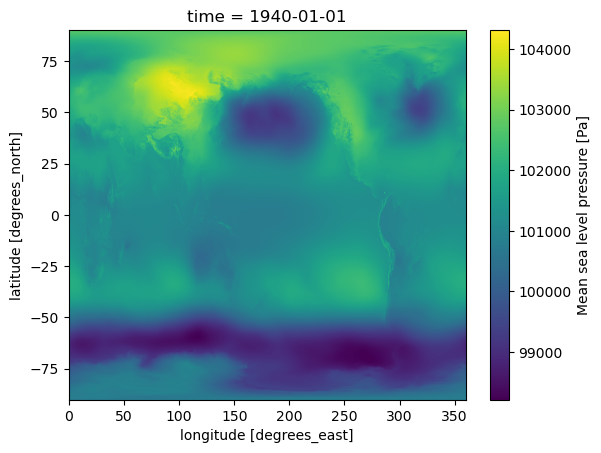

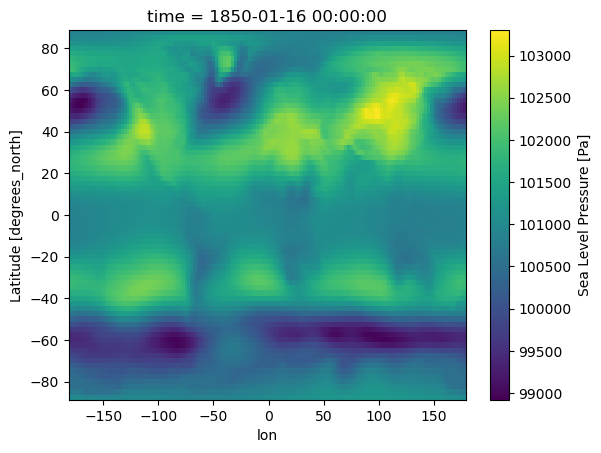

In [19]:
era5_og = xr.open_dataset("/gws/nopw/j04/leader_epesc/era5/era5.194001-202406.nc")
era5_og['msl'].isel(time=0).plot()
plt.show()

Had_og = xr.open_dataset("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_interp.nc")
Had_og['psl'].isel(time=0).plot()

In [40]:
all_data = AllDataComparisons(Path("/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/"),
                              Path("/gws/nopw/j04/extant/users/slbennie/")
)

#all_data.summary()
all_data.set_time_bounds_all(1850, 2014)
all_data.set_domain(lat_bounds=(20,80), lon_bounds=(-90,40))
all_data.set_season([12,1,2])
#all_data.experiments['historical'].models['HadGEM3-GC31-LL'].calc_seas_anomalies_all_members('psl')

#all_results = all_data.calc_R2('psl', 2)
#R2 = all_results['historical']['HadGEM3-GC31-LL']
#all_data.project_trend_EOF("psl",2)
#all_data.calc_R2("psl",2)
#all_data.projection_steps_plot("psl",2)

#print(R2)
#exp_name_CanESM5 = all_data.get_experiments_per_model('CanESM5')

#print(exp_name_CanESM5)
#all_results = all_data.project_trend_EOF('psl',2)
#all_data.R2_plot(all_results,2)
all_data.projection_steps_plot('psl',2)
#all_data.add_sum_experiment('psl')

#print(all_data.experiments['sum'])

#all_data.projection_steps_plot('psl', 2)
#all_data.R2_plot('psl',2)
#historical = all_data.experiments['historical']
#EOF = historical.calc_EOF_concat_all_models(
#                    varname='psl',
#                    max_modes=2
#)

(20, 80) (-90, 40)
[12, 1, 2]
hist-GHG ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
hist-aer ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
hist-sol ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
hist-volc ACCESS-ESM1-5
loading the linear trend for model: ACCESS-ESM1-5
Slope sum for ACCESS-ESM1-5 computed
hist-GHG CMCC-CM2-SR5
loading the linear trend for model: CMCC-CM2-SR5
hist-aer CMCC-CM2-SR5
loading the linear trend for model: CMCC-CM2-SR5
hist-volc CMCC-CM2-SR5
loading the linear trend for model: CMCC-CM2-SR5
Slope sum for CMCC-CM2-SR5 computed
hist-GHG CanESM5
loading the linear trend for model: CanESM5
hist-aer CanESM5
loading the linear trend for model: CanESM5
hist-sol CanESM5
loading the linear trend for model: CanESM5
hist-totalO3 CanESM5
loading the linear trend for model: CanESM5
hist-volc CanESM5
loading the linear trend for model: CanESM5
Slope sum for CanESM5 computed
hist-GHG FGOALS-g3
loading the linear trend for m

KeyboardInterrupt: 

In [31]:
ds = xr.open_dataset('/gws/nopw/j04/leader_epesc/era5/era5.194001-202406.nc')
print(ds['msl'])
ds = xr.open_dataset('/gws/nopw/j04/leader_epesc/CMIP6_SinglForcHistSimul/InterpolatedFlds/psl/historical/HadGEM3-GC31-LL/psl_mon_historical_HadGEM3-GC31-LL_r11i1p1f3_interp.nc')
print(ds['psl'])


<xarray.DataArray 'msl' (time: 1014, latitude: 721, longitude: 1440)> Size: 8GB
[1052775360 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-06-01
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Mean sea level pressure
    units:          Pa
<xarray.DataArray 'psl' (time: 1980, lat: 71, lon: 144)> Size: 162MB
[20243520 values with dtype=float64]
Coordinates:
  * time     (time) object 16kB 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lat      (lat) float64 568B -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon      (lon) float64 1kB -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Sea Level Pressure
    comment:        Sea Level Pressure
    uni